In [1]:
!virtualenv --system-site-packages -p python3 ./venv

created virtual environment in 6911ms CPython3Windows(dest=C:\Users\Omar Battisha\Documents\ML_Project\venv, clear=False, global=True) with seeder FromAppData pip=latest setuptools=latest wheel=latest app_data_dir=C:\Users\Omar Battisha\AppData\Local\pypa\virtualenv\seed-v1 via=copy


In [2]:
!.\venv\Scripts\activate

In [167]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow as tf
from sklearn.model_selection import *
from sklearn import *
import sklearn as sk
from cond_rnn import ConditionalRNN
import seaborn as sns

In [2]:
mortality=pd.read_csv("ml_standardized.csv")
mortality

,patient,hour_of_admission,age,copd,heart_failure,renal_disease,liver_disease,metastatic_cancer,hypertension,diabetes,heartrate,respiratoryrate,systolic_bp,diastolic_bp,temperature,oxygen_sat,days_in_hospital,mortality_30d
0,1,0.0,1.492560,-0.357087,-0.408341,-0.471739,-0.24034,-0.325241,-0.718434,-0.438873,1.485971,0.578418,-0.333105,-0.439685,-0.786980,-0.164075,11.0,0.0
1,1,1.0,1.492560,-0.357087,-0.408341,-0.471739,-0.24034,-0.325241,-0.718434,-0.438873,1.485971,0.578418,-0.333105,-0.439685,-0.786980,-0.164075,11.0,0.0
2,1,2.0,1.492560,-0.357087,-0.408341,-0.471739,-0.24034,-0.325241,-0.718434,-0.438873,0.794848,1.996810,-1.254795,-0.029665,-0.786980,-0.801719,11.0,0.0
3,1,3.0,1.492560,-0.357087,-0.408341,-0.471739,-0.24034,-0.325241,-0.718434,-0.438873,0.794848,1.996810,-1.254795,-0.029665,-0.786980,-0.801719,11.0,0.0
4,1,4.0,1.492560,-0.357087,-0.408341,-0.471739,-0.24034,-0.325241,-0.718434,-0.438873,0.794848,1.996810,-1.562025,-1.259723,-0.786980,-0.801719,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64495,2580,20.0,0.822287,-0.357087,-0.408341,-0.471739,-0.24034,3.074645,-0.718434,-0.438873,0.475868,1.051215,-0.376995,-0.849704,-3.239689,-0.801719,1.0,1.0
64496,2580,21.0,0.822287,-0.357087,-0.408341,-0.471739,-0.24034,3.074645,-0.718434,-0.438873,0.475868,1.051215,-0.376995,-0.849704,-3.239689,-0.801719,1.0,1.0
64497,2580,22.0,0.822287,-0.357087,-0.408341,-0.471739,-0.24034,3.074645,-0.718434,-0.438873,0.635358,1.228514,-1.518135,-1.259723,-1.502354,-2.316125,1.0,1.0
64498,2580,23.0,0.822287,-0.357087,-0.408341,-0.471739,-0.24034,3.074645,-0.718434,-0.438873,0.475868,2.469607,-1.518135,-1.259723,-0.889178,-1.864461,1.0,1.0


In [3]:
#Training and Testing Splits
np.random.seed(444)
selections=np.random.choice(2580, 2000, replace=False)
select=np.in1d(range(2580),selections)

In [4]:
#Cleaning Data for Entry into Conditional RNN
timevariant=mortality[["heartrate","respiratoryrate", "systolic_bp", "diastolic_bp", "temperature", "oxygen_sat"]].to_numpy().reshape(2580,25,6)
nottimevariant=mortality[["patient","hour_of_admission","age","copd","heart_failure","renal_disease","liver_disease", "metastatic_cancer", "hypertension", "diabetes"]].groupby("patient").mean().reset_index().drop(columns=["patient","hour_of_admission"]).to_numpy()
result=mortality[["patient","mortality_30d"]].groupby("patient").mean().reset_index()["mortality_30d"].to_numpy().reshape(2580,1).astype(int)

In [5]:
result=preprocessing.LabelEncoder().fit_transform(result)

c:\users\omar battisha\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [173]:
#Cond_RNN package

##Time Variant Inputs
inputs = Input(name='in',shape=(25,6)) # Each obseravation has 6 features at 25 time-steps each
#Dense Layer
x= Dense(32)(inputs)
#Dropout Layer
x= Dropout(0.5)(x)

##Time Invariant Inputs
inputs_aux = Input(name='in_aux', shape=[8]) # Each observation has 8 non time-variant features
#Dense Layer
x_aux= Dense(32, activation="sigmoid")(inputs_aux)
#Dropout Layer
x_aux= Dropout(0.5)(x_aux)

#ConditionalRNN Layer
y = ConditionalRNN(32, cell='LSTM')([x,x_aux])

#Outputs
predictions = Dense(1, activation="sigmoid")(y)

cond_model = Model(inputs=[inputs, inputs_aux], outputs=predictions)
cond_model.compile(optimizer='Adagrad', loss="binary_crossentropy", metrics=['AUC'])
data = timevariant[select] # Sample of 2000 patients with 6 features at 25 time-steps each
data_aux = nottimevariant[select] # Sample of 2000 patients with 8 non-time-series featuers each
labels = result[select] # For each of the 2000 patients, a corresponding (single) outcome variable (dead-1 or alive=0)

condrnn = cond_model.fit([data,data_aux], labels, epochs=255, validation_split=0)

Train on 2000 samples
Epoch 1/255
2000/2000 [==============================] - 5s 2ms/sample - loss: 0.5854 - AUC: 0.5837
Epoch 2/255
2000/2000 [==============================] - 2s 791us/sample - loss: 0.4708 - AUC: 0.6244
Epoch 3/255
2000/2000 [==============================] - 1s 732us/sample - loss: 0.3756 - AUC: 0.6716
Epoch 4/255
2000/2000 [==============================] - 1s 744us/sample - loss: 0.3042 - AUC: 0.7145
Epoch 5/255
2000/2000 [==============================] - 1s 697us/sample - loss: 0.2612 - AUC: 0.7701
Epoch 6/255
2000/2000 [==============================] - 1s 664us/sample - loss: 0.2473 - AUC: 0.7750
Epoch 7/255
2000/2000 [==============================] - 1s 674us/sample - loss: 0.2389 - AUC: 0.7876
Epoch 8/255
2000/2000 [==============================] - 1s 663us/sample - loss: 0.2335 - AUC: 0.7984
Epoch 9/255
2000/2000 [==============================] - 1s 676us/sample - loss: 0.2330 - AUC: 0.7975s - loss: 0.2
Epoch 10/255
2000/2000 [=========================

2000/2000 [==============================] - 1s 743us/sample - loss: 0.2120 - AUC: 0.8384
Epoch 80/255
2000/2000 [==============================] - 2s 756us/sample - loss: 0.2150 - AUC: 0.8342
Epoch 81/255
2000/2000 [==============================] - 1s 680us/sample - loss: 0.2160 - AUC: 0.8361
Epoch 82/255
2000/2000 [==============================] - 1s 673us/sample - loss: 0.2125 - AUC: 0.8377
Epoch 83/255
2000/2000 [==============================] - 2s 770us/sample - loss: 0.2154 - AUC: 0.8357
Epoch 84/255
2000/2000 [==============================] - 1s 672us/sample - loss: 0.2161 - AUC: 0.8335
Epoch 85/255
2000/2000 [==============================] - 1s 697us/sample - loss: 0.2152 - AUC: 0.8309
Epoch 86/255
2000/2000 [==============================] - 1s 707us/sample - loss: 0.2149 - AUC: 0.8336
Epoch 87/255
2000/2000 [==============================] - 1s 714us/sample - loss: 0.2120 - AUC: 0.8402
Epoch 88/255
2000/2000 [==============================] - 1s 694us/sample - loss: 0.21

2000/2000 [==============================] - 1s 691us/sample - loss: 0.2146 - AUC: 0.8377
Epoch 158/255
2000/2000 [==============================] - 1s 701us/sample - loss: 0.2120 - AUC: 0.8387
Epoch 159/255
2000/2000 [==============================] - 1s 704us/sample - loss: 0.2095 - AUC: 0.8409
Epoch 160/255
2000/2000 [==============================] - 1s 715us/sample - loss: 0.2118 - AUC: 0.8382
Epoch 161/255
2000/2000 [==============================] - 1s 669us/sample - loss: 0.2119 - AUC: 0.8420
Epoch 162/255
2000/2000 [==============================] - 1s 720us/sample - loss: 0.2095 - AUC: 0.8451
Epoch 163/255
2000/2000 [==============================] - 1s 708us/sample - loss: 0.2140 - AUC: 0.8373
Epoch 164/255
2000/2000 [==============================] - 1s 716us/sample - loss: 0.2096 - AUC: 0.8471
Epoch 165/255
2000/2000 [==============================] - 1s 712us/sample - loss: 0.2092 - AUC: 0.8467
Epoch 166/255
2000/2000 [==============================] - 1s 708us/sample - l

2000/2000 [==============================] - 1s 693us/sample - loss: 0.2071 - AUC: 0.8548
Epoch 236/255
2000/2000 [==============================] - 1s 694us/sample - loss: 0.2057 - AUC: 0.8533
Epoch 237/255
2000/2000 [==============================] - 1s 683us/sample - loss: 0.2105 - AUC: 0.8439
Epoch 238/255
2000/2000 [==============================] - 1s 696us/sample - loss: 0.2035 - AUC: 0.8546
Epoch 239/255
2000/2000 [==============================] - 1s 700us/sample - loss: 0.2084 - AUC: 0.8464
Epoch 240/255
2000/2000 [==============================] - 1s 689us/sample - loss: 0.2102 - AUC: 0.8440
Epoch 241/255
2000/2000 [==============================] - 1s 708us/sample - loss: 0.2104 - AUC: 0.8487
Epoch 242/255
2000/2000 [==============================] - 1s 675us/sample - loss: 0.2070 - AUC: 0.8534
Epoch 243/255
2000/2000 [==============================] - 1s 671us/sample - loss: 0.2086 - AUC: 0.8518
Epoch 244/255
2000/2000 [==============================] - 1s 701us/sample - l

In [174]:
#Evaluate Model
cond_model.evaluate([timevariant[~select], nottimevariant[~select]], result[~select])

580/580 [==============================] - 1s 2ms/sample - loss: 0.2027 - AUC: 0.8741


[0.2026709954286444, 0.87412477]

In [456]:
cond_model.summary()

Model: "model_269"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sigmoid (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
activation_515 (Activation)     (None, 8)            0           sigmoid[0][0]                    
__________________________________________________________________________________________________
dense_3695 (Dense)              (None, 64)           576         activation_515[0][0]             
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_243 (Ten [(1, None, 64)]      0           dense_3695[0][0]                 
__________________________________________________________________________________________

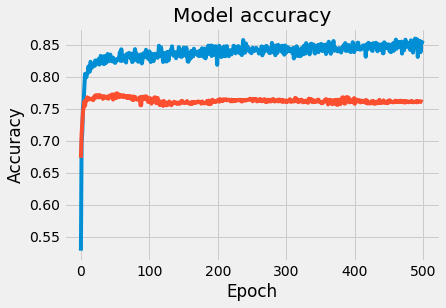

In [450]:
# Plot training & validation accuracy values
plots.plot(condrnn.history['AUC'])
plots.plot(condrnn.history['val_AUC'])
#plots.plot(condrnn.history['val_loss'])
plots.title('Model accuracy')
plots.ylabel('Accuracy')
plots.xlabel('Epoch')
plots.show()

In [92]:
x_train, x_test, y_train, y_test=train_test_split(timevariant, result, test_size=0.2, random_state=7, stratify=result)

In [120]:
#LSTM only

#Time Variant Inputs
inputs = Input(name='in',shape=(25,6)) # Each obseravation has 6 features at 25 time-steps each

#Activation Layer
x = Activation('sigmoid')(inputs)

#Dense Layer
x= Dense(32)(x)

#RNN Layer
x= LSTM(32, recurrent_dropout=0.5, dropout=0.5)(x)

#Outputs
predictions = Dense(1, activation="sigmoid")(x)

lstm_model = Model(inputs=inputs, outputs=predictions)
#sgd_modified=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
lstm_model.compile(optimizer="Adagrad", loss="binary_crossentropy", metrics=['AUC'])
data = timevariant[select] # Sample of 2000 patients with 6 features at 25 time-steps each
labels = result[select] # For each of the 2000 patients, a corresponding (single) outcome variable (dead-1 or alive=0)
lstm = lstm_model.fit(data, labels, epochs=1800, validation_split=0.2)

Train on 1600 samples, validate on 400 samples
Epoch 1/1800
1600/1600 [==============================] - 6s 4ms/sample - loss: 0.8642 - AUC: 0.4740 - val_loss: 0.7552 - val_AUC: 0.5139
Epoch 2/1800
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7813 - AUC: 0.4838 - val_loss: 0.7198 - val_AUC: 0.4965
Epoch 3/1800
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7451 - AUC: 0.4919 - val_loss: 0.7085 - val_AUC: 0.5429
Epoch 4/1800
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7269 - AUC: 0.5110 - val_loss: 0.7039 - val_AUC: 0.4629
Epoch 5/1800
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7180 - AUC: 0.5361 - val_loss: 0.7015 - val_AUC: 0.5164
Epoch 6/1800
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7129 - AUC: 0.5144 - val_loss: 0.7001 - val_AUC: 0.4985
Epoch 7/1800
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7095 - AUC: 0.5430 - val_loss: 0.6991 - val

KeyboardInterrupt: 

In [447]:
#Evaluate Model
lstm_model.evaluate(timevariant[~select], result[~select])

580/580 [==============================] - 0s 215us/sample - loss: 0.2165 - AUC: 0.8339


[0.2165022591064716, 0.83386254]

In [118]:
lstm_model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              [(None, 25, 6)]           0         
_________________________________________________________________
activation_49 (Activation)   (None, 25, 6)             0         
_________________________________________________________________
dense_338 (Dense)            (None, 25, 32)            224       
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_339 (Dense)            (None, 1)                 33        
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


KeyError: 'val_AUC'

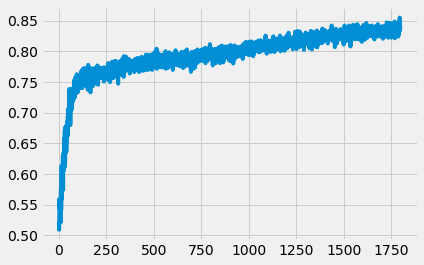

In [345]:
plots.plot(lstm.history['AUC'])
plots.plot(lstm.history['val_AUC'])

plots.title('Model accuracy')
plots.ylabel('Accuracy')
plots.xlabel('Epoch')
plots.show()

In [176]:
#Outputted Predictions do not follow 0-1 Format as Boolean Inputs
vlaues=cond_model.predict([timevariant[~select], nottimevariant[~select]])

In [177]:
vlaues=vlaues.reshape(580)

In [178]:
binaryoutputs=np.where(vlaues<((vlaues.max()-vlaues.min())/2), 0, 1)

In [179]:
data = {'y_Actual':    result[~select],
        'y_Predicted': binaryoutputs
        }
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

In [181]:
vdf=pd.DataFrame({"Predictions": vlaues, "Actual": result[~select]})
tf.math.confusion_matrix(labels=result[~select], predictions=vlaues)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[534,   0],
       [ 46,   0]])>

<Figure size 7200x3600 with 0 Axes>

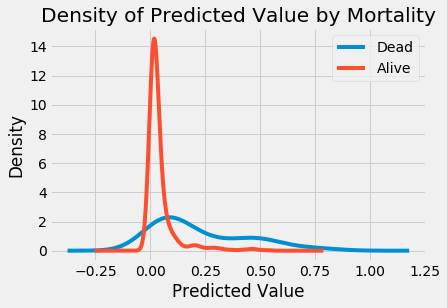

<Figure size 7200x3600 with 0 Axes>

In [182]:
axis=vdf[vdf.Actual==1].drop(columns="Actual").plot.density()
axis=vdf[vdf.Actual==0].drop(columns="Actual").plot.density(ax=axis)
plots.legend(["Dead", "Alive"])

plots.title('Density of Predicted Value by Mortality')
plots.xlabel('Predicted Value')

plots.figure(figsize=(100, 50))

In [189]:
binned

,Predictions,Actual
0,"(0.00594, 0.0569]",0.022026
1,"(0.0569, 0.107]",0.185185
2,"(0.107, 0.157]",0.210526
3,"(0.157, 0.207]",0.285714
4,"(0.207, 0.257]",0.285714
5,"(0.257, 0.307]",0.333333
6,"(0.307, 0.357]",0.000000
7,"(0.357, 0.407]",0.500000
8,"(0.407, 0.457]",0.600000
9,"(0.457, 0.507]",0.500000


<Figure size 7200x10800 with 0 Axes>

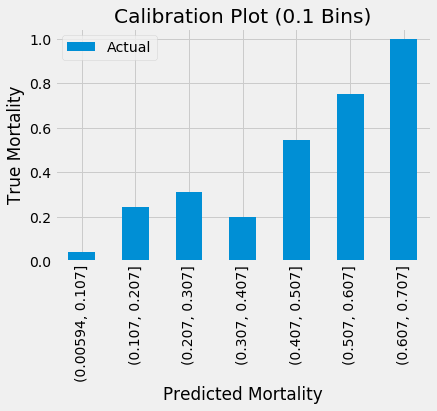

<Figure size 7200x10800 with 0 Axes>

In [191]:
binned=vdf.groupby(pd.cut(vdf["Predictions"], bins=np.arange(min(vdf["Predictions"]), max(vdf["Predictions"]), 0.1).tolist(), include_lowest=True)).mean()
binned=binned.drop(columns="Predictions").reset_index()
binned.plot.bar(x="Predictions", y="Actual", )
plots.title('Calibration Plot (0.1 Bins)')
plots.ylabel('True Mortality')
plots.xlabel('Predicted Mortality')
plots.figure(figsize=(100, 150))

Text(0.5, 0, 'Predicted Mortality')

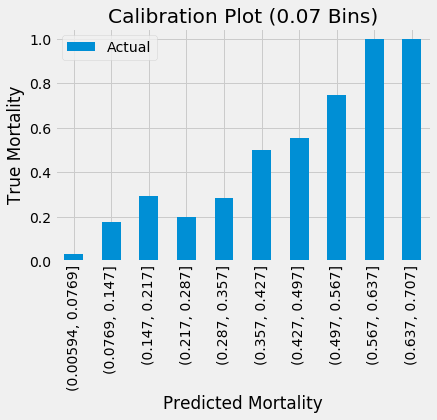

In [194]:
smallerrange=vdf.groupby(pd.cut(vdf["Predictions"], bins=np.arange(min(vdf["Predictions"]), max(vdf["Predictions"])-0.07, 0.07).tolist(), include_lowest=True)).mean()
smallerrange=smallerrange.drop(columns="Predictions").reset_index()
smallerrange.plot.bar(x="Predictions", y="Actual", )
plots.title('Calibration Plot (0.07 Bins)')
plots.ylabel('True Mortality')
plots.xlabel('Predicted Mortality')

In [93]:
condaucs=np.array([])
condpreds=np.array([])
for train_index,test_index in StratifiedKFold(5, random_state=777, shuffle=True).split(timevariant, result):
    ##Time Variant Inputs
    inputs = Input(name='in',shape=(25,6)) # Each obseravation has 6 features at 25 time-steps each
    #Dense Layer
    x= Dense(32)(inputs)
    #Dropout Layer
    x= Dropout(0.5)(x)
    ##Time Invariant Inputs
    inputs_aux = Input(name='sigmoid', shape=[8]) # Each observation has 8 non time-variant features
    #Dense Layer
    x_aux= Dense(32, activation="sigmoid")(inputs_aux)
    #Dropout Layer
    x_aux= Dropout(0.5)(x_aux)
    #ConditionalRNN Layer
    y = ConditionalRNN(64, cell='LSTM')([x,x_aux])
    
    #Outputs
    predictions = Dense(1, activation="sigmoid")(y)

    cond_model = Model(inputs=[inputs, inputs_aux], outputs=predictions)
    cond_model.compile(optimizer="Adagrad", loss="binary_crossentropy", metrics=['AUC'])
    data = timevariant[train_index] # Sample of 2000 patients with 6 features at 25 time-steps each
    data_aux = nottimevariant[train_index] # Sample of 2000 patients with 8 non-time-series featuers each
    labels = result[train_index] # For each of the 2000 patients, a corresponding (single) outcome variable (dead-1 or alive=0)
    condrnn = cond_model.fit([data,data_aux], labels, epochs=255, validation_split=0)
    condaucs=np.append(condaucs, cond_model.evaluate([timevariant[test_index], nottimevariant[test_index]], result[test_index])[1])
    condpreds=np.append(condpreds, cond_model.predict([timevariant[test_index], nottimevariant[test_index]]))

Train on 2064 samples
Epoch 1/255
2064/2064 [==============================] - 2s 827us/sample - loss: 0.5212 - AUC: 0.5855
Epoch 2/255
2064/2064 [==============================] - 1s 335us/sample - loss: 0.2821 - AUC: 0.7247
Epoch 3/255
2064/2064 [==============================] - 1s 323us/sample - loss: 0.2301 - AUC: 0.8006
Epoch 4/255
2064/2064 [==============================] - 1s 345us/sample - loss: 0.2215 - AUC: 0.8264
Epoch 5/255
2064/2064 [==============================] - 1s 417us/sample - loss: 0.2242 - AUC: 0.8162
Epoch 6/255
2064/2064 [==============================] - 1s 392us/sample - loss: 0.2210 - AUC: 0.8292
Epoch 7/255
2064/2064 [==============================] - 1s 392us/sample - loss: 0.2235 - AUC: 0.8196
Epoch 8/255
2064/2064 [==============================] - 1s 333us/sample - loss: 0.2169 - AUC: 0.8383
Epoch 9/255
2064/2064 [==============================] - 1s 313us/sample - loss: 0.2172 - AUC: 0.8324
Epoch 10/255
2064/2064 [==============================] - 1s

2064/2064 [==============================] - 1s 434us/sample - loss: 0.2060 - AUC: 0.8587
Epoch 80/255
2064/2064 [==============================] - 1s 367us/sample - loss: 0.2071 - AUC: 0.8545
Epoch 81/255
2064/2064 [==============================] - 1s 349us/sample - loss: 0.2093 - AUC: 0.8494
Epoch 82/255
2064/2064 [==============================] - 1s 341us/sample - loss: 0.2029 - AUC: 0.8620
Epoch 83/255
2064/2064 [==============================] - 1s 436us/sample - loss: 0.2053 - AUC: 0.8564s - loss: 0.2057 - AU
Epoch 84/255
2064/2064 [==============================] - 1s 519us/sample - loss: 0.2047 - AUC: 0.8558
Epoch 85/255
2064/2064 [==============================] - 1s 588us/sample - loss: 0.2076 - AUC: 0.8483s - loss: 0.2045 - AUC: 0
Epoch 86/255
2064/2064 [==============================] - 1s 557us/sample - loss: 0.2030 - AUC: 0.8607
Epoch 87/255
2064/2064 [==============================] - 1s 519us/sample - loss: 0.2025 - AUC: 0.8616
Epoch 88/255
2064/2064 [================

2064/2064 [==============================] - 1s 407us/sample - loss: 0.2018 - AUC: 0.8661
Epoch 158/255
2064/2064 [==============================] - 1s 347us/sample - loss: 0.1982 - AUC: 0.8708
Epoch 159/255
2064/2064 [==============================] - 1s 350us/sample - loss: 0.2034 - AUC: 0.8596
Epoch 160/255
2064/2064 [==============================] - 1s 328us/sample - loss: 0.2019 - AUC: 0.8629
Epoch 161/255
2064/2064 [==============================] - 1s 328us/sample - loss: 0.1983 - AUC: 0.8692
Epoch 162/255
2064/2064 [==============================] - 1s 363us/sample - loss: 0.1995 - AUC: 0.8667
Epoch 163/255
2064/2064 [==============================] - 1s 331us/sample - loss: 0.1997 - AUC: 0.8665
Epoch 164/255
2064/2064 [==============================] - 1s 330us/sample - loss: 0.2011 - AUC: 0.8646
Epoch 165/255
2064/2064 [==============================] - 1s 330us/sample - loss: 0.2001 - AUC: 0.8655
Epoch 166/255
2064/2064 [==============================] - 1s 330us/sample - l

2064/2064 [==============================] - 1s 359us/sample - loss: 0.1965 - AUC: 0.8732
Epoch 236/255
2064/2064 [==============================] - 1s 352us/sample - loss: 0.1968 - AUC: 0.8744
Epoch 237/255
2064/2064 [==============================] - 1s 345us/sample - loss: 0.1948 - AUC: 0.8778
Epoch 238/255
2064/2064 [==============================] - 1s 350us/sample - loss: 0.1950 - AUC: 0.8748
Epoch 239/255
2064/2064 [==============================] - 1s 405us/sample - loss: 0.1983 - AUC: 0.8697
Epoch 240/255
2064/2064 [==============================] - 1s 356us/sample - loss: 0.1961 - AUC: 0.8693
Epoch 241/255
2064/2064 [==============================] - 1s 347us/sample - loss: 0.1943 - AUC: 0.8773
Epoch 242/255
2064/2064 [==============================] - 1s 347us/sample - loss: 0.1920 - AUC: 0.8814
Epoch 243/255
2064/2064 [==============================] - 1s 346us/sample - loss: 0.1963 - AUC: 0.8765
Epoch 244/255
2064/2064 [==============================] - 1s 350us/sample - l

2064/2064 [==============================] - 1s 392us/sample - loss: 0.2042 - AUC: 0.8530
Epoch 58/255
2064/2064 [==============================] - 1s 393us/sample - loss: 0.2037 - AUC: 0.8553
Epoch 59/255
2064/2064 [==============================] - 1s 390us/sample - loss: 0.2047 - AUC: 0.8524
Epoch 60/255
2064/2064 [==============================] - 1s 390us/sample - loss: 0.2038 - AUC: 0.8579
Epoch 61/255
2064/2064 [==============================] - 1s 396us/sample - loss: 0.2067 - AUC: 0.8515
Epoch 62/255
2064/2064 [==============================] - 1s 389us/sample - loss: 0.2021 - AUC: 0.8569
Epoch 63/255
2064/2064 [==============================] - 1s 386us/sample - loss: 0.2066 - AUC: 0.8545
Epoch 64/255
2064/2064 [==============================] - 1s 376us/sample - loss: 0.2056 - AUC: 0.8542
Epoch 65/255
2064/2064 [==============================] - 1s 386us/sample - loss: 0.2054 - AUC: 0.8542
Epoch 66/255
2064/2064 [==============================] - 1s 390us/sample - loss: 0.20

2064/2064 [==============================] - 1s 398us/sample - loss: 0.1996 - AUC: 0.8677
Epoch 137/255
2064/2064 [==============================] - 1s 394us/sample - loss: 0.1986 - AUC: 0.8702
Epoch 138/255
2064/2064 [==============================] - 1s 394us/sample - loss: 0.1989 - AUC: 0.8651
Epoch 139/255
2064/2064 [==============================] - 1s 400us/sample - loss: 0.1987 - AUC: 0.8663
Epoch 140/255
2064/2064 [==============================] - 1s 401us/sample - loss: 0.1960 - AUC: 0.8740
Epoch 141/255
2064/2064 [==============================] - 1s 424us/sample - loss: 0.1976 - AUC: 0.8726
Epoch 142/255
2064/2064 [==============================] - 1s 406us/sample - loss: 0.1937 - AUC: 0.8803
Epoch 143/255
2064/2064 [==============================] - 1s 395us/sample - loss: 0.1985 - AUC: 0.8673
Epoch 144/255
2064/2064 [==============================] - 1s 398us/sample - loss: 0.1945 - AUC: 0.8753
Epoch 145/255
2064/2064 [==============================] - 1s 397us/sample - l

2064/2064 [==============================] - 2s 826us/sample - loss: 0.1953 - AUC: 0.8723
Epoch 214/255
2064/2064 [==============================] - 2s 831us/sample - loss: 0.1888 - AUC: 0.8838
Epoch 215/255
2064/2064 [==============================] - 2s 812us/sample - loss: 0.1920 - AUC: 0.8804
Epoch 216/255
2064/2064 [==============================] - 2s 831us/sample - loss: 0.1926 - AUC: 0.8748
Epoch 217/255
2064/2064 [==============================] - 2s 832us/sample - loss: 0.1945 - AUC: 0.8752
Epoch 218/255
2064/2064 [==============================] - 2s 825us/sample - loss: 0.1920 - AUC: 0.8792
Epoch 219/255
2064/2064 [==============================] - 2s 838us/sample - loss: 0.1955 - AUC: 0.8733
Epoch 220/255
2064/2064 [==============================] - 2s 843us/sample - loss: 0.1915 - AUC: 0.8832
Epoch 221/255
2064/2064 [==============================] - 2s 825us/sample - loss: 0.1920 - AUC: 0.8795
Epoch 222/255
2064/2064 [==============================] - 2s 809us/sample - l

2064/2064 [==============================] - 2s 825us/sample - loss: 0.2080 - AUC: 0.8432
Epoch 36/255
2064/2064 [==============================] - 2s 842us/sample - loss: 0.2070 - AUC: 0.8489s - loss: 0.2087 - AU
Epoch 37/255
2064/2064 [==============================] - 2s 854us/sample - loss: 0.2080 - AUC: 0.8473
Epoch 38/255
2064/2064 [==============================] - 2s 842us/sample - loss: 0.2026 - AUC: 0.8594
Epoch 39/255
2064/2064 [==============================] - 2s 844us/sample - loss: 0.2050 - AUC: 0.8501
Epoch 40/255
2064/2064 [==============================] - 2s 835us/sample - loss: 0.2034 - AUC: 0.8535
Epoch 41/255
2064/2064 [==============================] - 2s 853us/sample - loss: 0.2066 - AUC: 0.8472
Epoch 42/255
2064/2064 [==============================] - 2s 847us/sample - loss: 0.2044 - AUC: 0.8544s - loss:
Epoch 43/255
2064/2064 [==============================] - 2s 842us/sample - loss: 0.2059 - AUC: 0.8477
Epoch 44/255
2064/2064 [==============================] 

2064/2064 [==============================] - 2s 820us/sample - loss: 0.1977 - AUC: 0.8667
Epoch 114/255
2064/2064 [==============================] - 2s 853us/sample - loss: 0.2001 - AUC: 0.8641
Epoch 115/255
2064/2064 [==============================] - 2s 842us/sample - loss: 0.2026 - AUC: 0.8570
Epoch 116/255
2064/2064 [==============================] - 2s 839us/sample - loss: 0.1994 - AUC: 0.8639
Epoch 117/255
2064/2064 [==============================] - 2s 829us/sample - loss: 0.1992 - AUC: 0.8612
Epoch 118/255
2064/2064 [==============================] - 2s 850us/sample - loss: 0.1966 - AUC: 0.8657
Epoch 119/255
2064/2064 [==============================] - 2s 858us/sample - loss: 0.2030 - AUC: 0.8560
Epoch 120/255
2064/2064 [==============================] - 2s 857us/sample - loss: 0.1975 - AUC: 0.8653
Epoch 121/255
2064/2064 [==============================] - 2s 837us/sample - loss: 0.1972 - AUC: 0.8650
Epoch 122/255
2064/2064 [==============================] - 2s 826us/sample - l

2064/2064 [==============================] - 2s 835us/sample - loss: 0.1974 - AUC: 0.8658
Epoch 191/255
2064/2064 [==============================] - 2s 841us/sample - loss: 0.1954 - AUC: 0.8700
Epoch 192/255
2064/2064 [==============================] - 2s 829us/sample - loss: 0.1921 - AUC: 0.8793
Epoch 193/255
2064/2064 [==============================] - 2s 829us/sample - loss: 0.1927 - AUC: 0.8746
Epoch 194/255
2064/2064 [==============================] - 2s 823us/sample - loss: 0.1949 - AUC: 0.8704
Epoch 195/255
2064/2064 [==============================] - 2s 850us/sample - loss: 0.1923 - AUC: 0.8788
Epoch 196/255
2064/2064 [==============================] - 2s 843us/sample - loss: 0.1928 - AUC: 0.8751
Epoch 197/255
2064/2064 [==============================] - 2s 839us/sample - loss: 0.1932 - AUC: 0.8775
Epoch 198/255
2064/2064 [==============================] - 2s 838us/sample - loss: 0.1963 - AUC: 0.8695
Epoch 199/255
2064/2064 [==============================] - 2s 818us/sample - l

2064/2064 [==============================] - 2s 800us/sample - loss: 0.2150 - AUC: 0.8313
Epoch 13/255
2064/2064 [==============================] - 2s 815us/sample - loss: 0.2135 - AUC: 0.8354
Epoch 14/255
2064/2064 [==============================] - 2s 807us/sample - loss: 0.2126 - AUC: 0.8424
Epoch 15/255
2064/2064 [==============================] - 2s 817us/sample - loss: 0.2146 - AUC: 0.8368
Epoch 16/255
2064/2064 [==============================] - 2s 839us/sample - loss: 0.2123 - AUC: 0.8364
Epoch 17/255
2064/2064 [==============================] - 2s 807us/sample - loss: 0.2141 - AUC: 0.8356
Epoch 18/255
2064/2064 [==============================] - 2s 828us/sample - loss: 0.2124 - AUC: 0.8369
Epoch 19/255
2064/2064 [==============================] - 2s 841us/sample - loss: 0.2106 - AUC: 0.8367
Epoch 20/255
2064/2064 [==============================] - 2s 811us/sample - loss: 0.2111 - AUC: 0.8441
Epoch 21/255
2064/2064 [==============================] - 2s 762us/sample - loss: 0.21

Epoch 91/255
2064/2064 [==============================] - 2s 804us/sample - loss: 0.2013 - AUC: 0.8612
Epoch 92/255
2064/2064 [==============================] - 2s 821us/sample - loss: 0.2027 - AUC: 0.8563
Epoch 93/255
2064/2064 [==============================] - 2s 817us/sample - loss: 0.1983 - AUC: 0.8699
Epoch 94/255
2064/2064 [==============================] - 2s 797us/sample - loss: 0.1993 - AUC: 0.8670s - loss: 0
Epoch 95/255
2064/2064 [==============================] - 2s 815us/sample - loss: 0.1988 - AUC: 0.8675
Epoch 96/255
2064/2064 [==============================] - 2s 832us/sample - loss: 0.1974 - AUC: 0.8700
Epoch 97/255
2064/2064 [==============================] - 2s 834us/sample - loss: 0.1984 - AUC: 0.8714
Epoch 98/255
2064/2064 [==============================] - 2s 827us/sample - loss: 0.2017 - AUC: 0.8644
Epoch 99/255
2064/2064 [==============================] - 2s 838us/sample - loss: 0.2036 - AUC: 0.8582
Epoch 100/255
2064/2064 [==============================] - 2s 

2064/2064 [==============================] - 2s 824us/sample - loss: 0.1900 - AUC: 0.8827
Epoch 170/255
2064/2064 [==============================] - 2s 812us/sample - loss: 0.1901 - AUC: 0.8849
Epoch 171/255
2064/2064 [==============================] - 2s 826us/sample - loss: 0.1952 - AUC: 0.8749
Epoch 172/255
2064/2064 [==============================] - 2s 832us/sample - loss: 0.1918 - AUC: 0.8807s - loss: 0.1913 - AUC: 0.
Epoch 173/255
2064/2064 [==============================] - 2s 817us/sample - loss: 0.1936 - AUC: 0.8749
Epoch 174/255
2064/2064 [==============================] - 2s 826us/sample - loss: 0.1950 - AUC: 0.8699
Epoch 175/255
2064/2064 [==============================] - 2s 828us/sample - loss: 0.1870 - AUC: 0.8879
Epoch 176/255
2064/2064 [==============================] - 2s 820us/sample - loss: 0.1936 - AUC: 0.8761
Epoch 177/255
2064/2064 [==============================] - 2s 817us/sample - loss: 0.1903 - AUC: 0.8819
Epoch 178/255
2064/2064 [===========================

2064/2064 [==============================] - 2s 822us/sample - loss: 0.1874 - AUC: 0.8890
Epoch 247/255
2064/2064 [==============================] - 2s 838us/sample - loss: 0.1837 - AUC: 0.8954
Epoch 248/255
2064/2064 [==============================] - 2s 848us/sample - loss: 0.1883 - AUC: 0.8821
Epoch 249/255
2064/2064 [==============================] - 2s 857us/sample - loss: 0.1860 - AUC: 0.8913
Epoch 250/255
2064/2064 [==============================] - 2s 859us/sample - loss: 0.1902 - AUC: 0.8801
Epoch 251/255
2064/2064 [==============================] - 2s 850us/sample - loss: 0.1882 - AUC: 0.8887
Epoch 252/255
2064/2064 [==============================] - 2s 828us/sample - loss: 0.1867 - AUC: 0.8896
Epoch 253/255
2064/2064 [==============================] - 2s 839us/sample - loss: 0.1851 - AUC: 0.8908s - loss: 0.1899 - AU
Epoch 254/255
2064/2064 [==============================] - 2s 850us/sample - loss: 0.1861 - AUC: 0.8912
Epoch 255/255
516/516 [==============================] - 

2064/2064 [==============================] - 2s 786us/sample - loss: 0.2061 - AUC: 0.8531
Epoch 69/255
2064/2064 [==============================] - 2s 785us/sample - loss: 0.2043 - AUC: 0.8569
Epoch 70/255
2064/2064 [==============================] - 2s 776us/sample - loss: 0.2008 - AUC: 0.8612
Epoch 71/255
2064/2064 [==============================] - 2s 763us/sample - loss: 0.2019 - AUC: 0.8629
Epoch 72/255
2064/2064 [==============================] - 2s 739us/sample - loss: 0.2046 - AUC: 0.8572
Epoch 73/255
2064/2064 [==============================] - 2s 756us/sample - loss: 0.2016 - AUC: 0.8600
Epoch 74/255
2064/2064 [==============================] - 2s 766us/sample - loss: 0.2025 - AUC: 0.8602
Epoch 75/255
2064/2064 [==============================] - 2s 807us/sample - loss: 0.1996 - AUC: 0.8681
Epoch 76/255
2064/2064 [==============================] - 2s 760us/sample - loss: 0.2007 - AUC: 0.8652
Epoch 77/255
2064/2064 [==============================] - 1s 705us/sample - loss: 0.19

2064/2064 [==============================] - 2s 767us/sample - loss: 0.1929 - AUC: 0.8797
Epoch 147/255
2064/2064 [==============================] - 1s 677us/sample - loss: 0.1988 - AUC: 0.8676
Epoch 148/255
2064/2064 [==============================] - 1s 632us/sample - loss: 0.1965 - AUC: 0.8722s - loss: 0.215
Epoch 149/255
2064/2064 [==============================] - 1s 706us/sample - loss: 0.1956 - AUC: 0.8732
Epoch 150/255
2064/2064 [==============================] - 2s 829us/sample - loss: 0.1924 - AUC: 0.8798
Epoch 151/255
2064/2064 [==============================] - 2s 812us/sample - loss: 0.1937 - AUC: 0.8765
Epoch 152/255
2064/2064 [==============================] - 2s 755us/sample - loss: 0.1894 - AUC: 0.8836
Epoch 153/255
2064/2064 [==============================] - 2s 807us/sample - loss: 0.1977 - AUC: 0.8684
Epoch 154/255
2064/2064 [==============================] - 2s 768us/sample - loss: 0.1955 - AUC: 0.8748
Epoch 155/255
2064/2064 [==============================] - 2s 7

2064/2064 [==============================] - 2s 823us/sample - loss: 0.1909 - AUC: 0.8808
Epoch 224/255
2064/2064 [==============================] - 2s 815us/sample - loss: 0.1901 - AUC: 0.8839
Epoch 225/255
2064/2064 [==============================] - 2s 815us/sample - loss: 0.1916 - AUC: 0.8778
Epoch 226/255
2064/2064 [==============================] - 2s 803us/sample - loss: 0.1905 - AUC: 0.8815
Epoch 227/255
2064/2064 [==============================] - 2s 816us/sample - loss: 0.1876 - AUC: 0.8884
Epoch 228/255
2064/2064 [==============================] - 2s 837us/sample - loss: 0.1902 - AUC: 0.8828
Epoch 229/255
2064/2064 [==============================] - 2s 820us/sample - loss: 0.1905 - AUC: 0.8812
Epoch 230/255
2064/2064 [==============================] - 2s 819us/sample - loss: 0.1906 - AUC: 0.8861
Epoch 231/255
2064/2064 [==============================] - 2s 815us/sample - loss: 0.1896 - AUC: 0.8853
Epoch 232/255
2064/2064 [==============================] - 2s 802us/sample - l

In [94]:
np.mean(condaucs)

0.8265437722206116

In [95]:
condaucs

array([0.8171218 , 0.80632877, 0.84487808, 0.82862639, 0.83576381])

In [35]:
resultstable=pd.DataFrame(data={"Optimizer": [], "# of LSTM Layers":[], "# of Dense Layers":[], "# of Epochs":[], "Mean AUC":[]})
resultstable=resultstable.append({"Optimizer": "RMSprop", "# of LSTM Layers":32, "# of Dense Layers":32, "# of Epochs":25, "Mean AUC":0.8044620275497436}, ignore_index=True)
resultstable=resultstable.append({"Optimizer": "RMSprop", "# of LSTM Layers":64, "# of Dense Layers":64, "# of Epochs":40, "Mean AUC":0.7935864925384521}, ignore_index=True)
resultstable=resultstable.append({"Optimizer": "SGD", "# of LSTM Layers":32, "# of Dense Layers":32, "# of Epochs":180, "Mean AUC":0.8024403810501098}, ignore_index=True)
resultstable=resultstable.append({"Optimizer": "SGD", "# of LSTM Layers":16, "# of Dense Layers":16, "# of Epochs":459, "Mean AUC":0.7890304684638977}, ignore_index=True)
resultstable=resultstable.append({"Optimizer": "SGD", "# of LSTM Layers":64, "# of Dense Layers":64, "# of Epochs":200, "Mean AUC":0.8080680251121521}, ignore_index=True)
resultstable=resultstable.append({"Optimizer": "SGD", "# of LSTM Layers":256, "# of Dense Layers":256, "# of Epochs":215, "Mean AUC":0.8080519676208496}, ignore_index=True)
resultstable=resultstable.append({"Optimizer": "Adagrad", "# of LSTM Layers":32, "# of Dense Layers":32, "# of Epochs":255, "Mean AUC":0.8094108819961547}, ignore_index=True)
resultstable=resultstable.append({"Optimizer": "Adagrad", "# of LSTM Layers":64, "# of Dense Layers":64, "# of Epochs":50, "Mean AUC":0.8027197480201721}, ignore_index=True)

resultstable

,Optimizer,# of LSTM Layers,# of Dense Layers,# of Epochs,Mean AUC
0,RMSprop,32.0,32.0,25.0,0.804462
1,RMSprop,64.0,64.0,40.0,0.793586
2,SGD,32.0,32.0,180.0,0.802440
3,SGD,16.0,16.0,459.0,0.789030
4,SGD,64.0,64.0,200.0,0.808068
5,SGD,256.0,256.0,215.0,0.808052
6,Adagrad,32.0,32.0,255.0,0.809411
7,Adagrad,64.0,64.0,50.0,0.802720


In [143]:
aucs=np.array([])
for train_index,test_index in StratifiedKFold(5, random_state=777).split(timevariant, result):
    #Time Variant Inputs
    inputs = Input(name='in',shape=(25,6)) # Each obseravation has 6 features at 25 time-steps each
    #Activation Layer
    x = Activation('sigmoid')(inputs)
    #Dense Layer
    x= Dense(32)(x)
    #RNN Layer
    x= LSTM(32, recurrent_dropout=0.5, dropout=0.5)(x)
    #Outputs
    predictions = Dense(1, activation="sigmoid")(x)

    lstm_model = Model(inputs=inputs, outputs=predictions)
    #sgd_modified=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
    lstm_model.compile(optimizer="RMSprop", loss="binary_crossentropy", metrics=['AUC'])
    data = timevariant[train_index] # Sample of 2000 patients with 6 features at 25 time-steps each
    labels = result[train_index] # For each of the 2000 patients, a corresponding (single) outcome variable (dead-1 or alive=0)
    lstm = lstm_model.fit(data, labels, epochs=1800, validation_split=0)
    aucs=np.append(aucs, lstm_model.evaluate(timevariant[test_index], result[test_index])[1])
    lstm_model.evaluate(timevariant[test_index], result[test_index])

c:\users\omar battisha\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train on 2064 samples
Epoch 1/1800
2064/2064 [==============================] - 7s 3ms/sample - loss: 0.4926 - AUC: 0.4980
Epoch 2/1800
2064/2064 [==============================] - 2s 850us/sample - loss: 0.3262 - AUC: 0.5020
Epoch 3/1800
2064/2064 [==============================] - 2s 796us/sample - loss: 0.2945 - AUC: 0.5026
Epoch 4/1800
2064/2064 [==============================] - 2s 798us/sample - loss: 0.2846 - AUC: 0.5224
Epoch 5/1800
2064/2064 [==============================] - 2s 804us/sample - loss: 0.2811 - AUC: 0.5226
Epoch 6/1800
2064/2064 [==============================] - 2s 794us/sample - loss: 0.2800 - AUC: 0.5007
Epoch 7/1800
2064/2064 [==============================] - 2s 814us/sample - loss: 0.2808 - AUC: 0.4924
Epoch 8/1800
2064/2064 [==============================] - 2s 786us/sample - loss: 0.2773 - AUC: 0.5427
Epoch 9/1800
2064/2064 [==============================] - 2s 790us/sample - loss: 0.2779 - AUC: 0.5428
Epoch 10/1800
2064/2064 [============================

2064/2064 [==============================] - 2s 806us/sample - loss: 0.2419 - AUC: 0.7488
Epoch 158/1800
2064/2064 [==============================] - 2s 762us/sample - loss: 0.2400 - AUC: 0.7609
Epoch 159/1800
2064/2064 [==============================] - 2s 754us/sample - loss: 0.2384 - AUC: 0.7558
Epoch 160/1800
2064/2064 [==============================] - 2s 757us/sample - loss: 0.2393 - AUC: 0.7648
Epoch 161/1800
2064/2064 [==============================] - 2s 760us/sample - loss: 0.2389 - AUC: 0.7604
Epoch 162/1800
2064/2064 [==============================] - 2s 754us/sample - loss: 0.2401 - AUC: 0.7555
Epoch 163/1800
2064/2064 [==============================] - 2s 761us/sample - loss: 0.2437 - AUC: 0.7381
Epoch 164/1800
2064/2064 [==============================] - 2s 753us/sample - loss: 0.2418 - AUC: 0.7468
Epoch 165/1800
2064/2064 [==============================] - 2s 745us/sample - loss: 0.2443 - AUC: 0.7496
Epoch 166/1800
2064/2064 [==============================] - 2s 751us/s

2064/2064 [==============================] - 1s 673us/sample - loss: 0.2371 - AUC: 0.7746
Epoch 314/1800
2064/2064 [==============================] - 1s 688us/sample - loss: 0.2348 - AUC: 0.7807
Epoch 315/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2349 - AUC: 0.7704
Epoch 316/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2341 - AUC: 0.7793
Epoch 317/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2362 - AUC: 0.7729
Epoch 318/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2364 - AUC: 0.7725
Epoch 319/1800
2064/2064 [==============================] - 1s 695us/sample - loss: 0.2334 - AUC: 0.7827
Epoch 320/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2312 - AUC: 0.7888
Epoch 321/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2363 - AUC: 0.7669
Epoch 322/1800
2064/2064 [==============================] - 1s 679us/s

Epoch 391/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2294 - AUC: 0.7984
Epoch 392/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2314 - AUC: 0.7835
Epoch 393/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2358 - AUC: 0.7779
Epoch 394/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2339 - AUC: 0.7757
Epoch 395/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2323 - AUC: 0.7837
Epoch 396/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2332 - AUC: 0.7837
Epoch 397/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2319 - AUC: 0.7840
Epoch 398/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2335 - AUC: 0.7813
Epoch 399/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2350 - AUC: 0.7819
Epoch 400/1800
2064/2064 [=============================

2064/2064 [==============================] - 1s 675us/sample - loss: 0.2286 - AUC: 0.7978
Epoch 546/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2322 - AUC: 0.7850
Epoch 547/1800
2064/2064 [==============================] - 1s 682us/sample - loss: 0.2307 - AUC: 0.7908
Epoch 548/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2308 - AUC: 0.7900
Epoch 549/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2277 - AUC: 0.8033
Epoch 550/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2290 - AUC: 0.7929
Epoch 551/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2286 - AUC: 0.7879
Epoch 552/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2336 - AUC: 0.7787
Epoch 553/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2292 - AUC: 0.7951
Epoch 554/1800
2064/2064 [==============================] - 1s 675us/s

2064/2064 [==============================] - 1s 613us/sample - loss: 0.2272 - AUC: 0.8035
Epoch 701/1800
2064/2064 [==============================] - 1s 605us/sample - loss: 0.2296 - AUC: 0.7964s - loss: 0.2187 - 
Epoch 702/1800
2064/2064 [==============================] - 1s 605us/sample - loss: 0.2282 - AUC: 0.7983
Epoch 703/1800
2064/2064 [==============================] - 1s 606us/sample - loss: 0.2258 - AUC: 0.8060
Epoch 704/1800
2064/2064 [==============================] - 1s 601us/sample - loss: 0.2303 - AUC: 0.7950
Epoch 705/1800
2064/2064 [==============================] - 1s 604us/sample - loss: 0.2249 - AUC: 0.8050
Epoch 706/1800
2064/2064 [==============================] - 1s 611us/sample - loss: 0.2291 - AUC: 0.7924
Epoch 707/1800
2064/2064 [==============================] - 1s 617us/sample - loss: 0.2295 - AUC: 0.7983
Epoch 708/1800
2064/2064 [==============================] - 1s 600us/sample - loss: 0.2251 - AUC: 0.8078
Epoch 709/1800
2064/2064 [=========================

Epoch 776/1800
2064/2064 [==============================] - 1s 634us/sample - loss: 0.2302 - AUC: 0.7906
Epoch 777/1800
2064/2064 [==============================] - 1s 620us/sample - loss: 0.2237 - AUC: 0.8118
Epoch 778/1800
2064/2064 [==============================] - 1s 619us/sample - loss: 0.2262 - AUC: 0.8107s - loss: 0.2162 - AUC:
Epoch 779/1800
2064/2064 [==============================] - 1s 615us/sample - loss: 0.2256 - AUC: 0.8022
Epoch 780/1800
2064/2064 [==============================] - 1s 622us/sample - loss: 0.2263 - AUC: 0.8057
Epoch 781/1800
2064/2064 [==============================] - 1s 612us/sample - loss: 0.2253 - AUC: 0.8088s - loss: 0.2307 - AUC: 0.
Epoch 782/1800
2064/2064 [==============================] - 1s 615us/sample - loss: 0.2257 - AUC: 0.8124
Epoch 783/1800
2064/2064 [==============================] - 1s 615us/sample - loss: 0.2258 - AUC: 0.7960
Epoch 784/1800
2064/2064 [==============================] - 1s 615us/sample - loss: 0.2249 - AUC: 0.8083
Epoch 

2064/2064 [==============================] - 1s 655us/sample - loss: 0.2236 - AUC: 0.8132
Epoch 928/1800
2064/2064 [==============================] - 1s 641us/sample - loss: 0.2291 - AUC: 0.7964
Epoch 929/1800
2064/2064 [==============================] - 1s 647us/sample - loss: 0.2262 - AUC: 0.8011s - loss: 0.2158 - AUC: 
Epoch 930/1800
2064/2064 [==============================] - 1s 647us/sample - loss: 0.2236 - AUC: 0.8082
Epoch 931/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2287 - AUC: 0.7950s - loss: 0.2273 - AUC: 0.8
Epoch 932/1800
2064/2064 [==============================] - 1s 653us/sample - loss: 0.2237 - AUC: 0.8142
Epoch 933/1800
2064/2064 [==============================] - 1s 642us/sample - loss: 0.2250 - AUC: 0.8078
Epoch 934/1800
2064/2064 [==============================] - 1s 648us/sample - loss: 0.2217 - AUC: 0.8161
Epoch 935/1800
2064/2064 [==============================] - 1s 655us/sample - loss: 0.2252 - AUC: 0.8066
Epoch 936/1800
2064

2064/2064 [==============================] - 1s 662us/sample - loss: 0.2197 - AUC: 0.8212
Epoch 1080/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2189 - AUC: 0.8252
Epoch 1081/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2176 - AUC: 0.8283
Epoch 1082/1800
2064/2064 [==============================] - 1s 660us/sample - loss: 0.2176 - AUC: 0.8299
Epoch 1083/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2185 - AUC: 0.8265
Epoch 1084/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2214 - AUC: 0.8192
Epoch 1085/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2197 - AUC: 0.8229
Epoch 1086/1800
2064/2064 [==============================] - 1s 647us/sample - loss: 0.2207 - AUC: 0.8179
Epoch 1087/1800
2064/2064 [==============================] - 1s 653us/sample - loss: 0.2171 - AUC: 0.8310
Epoch 1088/1800
2064/2064 [==============================] - 1

Epoch 1231/1800
2064/2064 [==============================] - 1s 658us/sample - loss: 0.2272 - AUC: 0.8113
Epoch 1232/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2244 - AUC: 0.8138
Epoch 1233/1800
2064/2064 [==============================] - 1s 662us/sample - loss: 0.2244 - AUC: 0.8083
Epoch 1234/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2196 - AUC: 0.8215
Epoch 1235/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2231 - AUC: 0.8216
Epoch 1236/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2235 - AUC: 0.8161
Epoch 1237/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2215 - AUC: 0.8220
Epoch 1238/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2223 - AUC: 0.8177s - loss: 0.2151 - A
Epoch 1239/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2231 - AUC: 0.8099
Epoch 1240/1800
2064/2064 

Epoch 1382/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2164 - AUC: 0.8265
Epoch 1383/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2154 - AUC: 0.8272
Epoch 1384/1800
2064/2064 [==============================] - 1s 662us/sample - loss: 0.2143 - AUC: 0.8370
Epoch 1385/1800
2064/2064 [==============================] - 1s 655us/sample - loss: 0.2200 - AUC: 0.8185
Epoch 1386/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2146 - AUC: 0.8347
Epoch 1387/1800
2064/2064 [==============================] - 1s 684us/sample - loss: 0.2144 - AUC: 0.8356
Epoch 1388/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2165 - AUC: 0.8327
Epoch 1389/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2199 - AUC: 0.8215
Epoch 1390/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2127 - AUC: 0.8377
Epoch 1391/1800
2064/2064 [===================

2064/2064 [==============================] - 1s 655us/sample - loss: 0.2155 - AUC: 0.8321
Epoch 1536/1800
2064/2064 [==============================] - 1s 644us/sample - loss: 0.2145 - AUC: 0.8339
Epoch 1537/1800
2064/2064 [==============================] - 1s 635us/sample - loss: 0.2187 - AUC: 0.8289
Epoch 1538/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2143 - AUC: 0.8315
Epoch 1539/1800
2064/2064 [==============================] - 1s 639us/sample - loss: 0.2171 - AUC: 0.8300
Epoch 1540/1800
2064/2064 [==============================] - 1s 639us/sample - loss: 0.2175 - AUC: 0.8298
Epoch 1541/1800
2064/2064 [==============================] - 1s 643us/sample - loss: 0.2133 - AUC: 0.8386
Epoch 1542/1800
2064/2064 [==============================] - 1s 648us/sample - loss: 0.2163 - AUC: 0.8271s - loss: 0.1980 - AUC: 0.84 - ETA: 0s - loss: 0.2145 - AUC: 0.8
Epoch 1543/1800
2064/2064 [==============================] - 1s 638us/sample - loss: 0.2145 - AUC: 0.838

Epoch 1611/1800
2064/2064 [==============================] - 1s 652us/sample - loss: 0.2096 - AUC: 0.8427
Epoch 1612/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2137 - AUC: 0.8410
Epoch 1613/1800
2064/2064 [==============================] - 1s 719us/sample - loss: 0.2112 - AUC: 0.8394
Epoch 1614/1800
2064/2064 [==============================] - 2s 801us/sample - loss: 0.2131 - AUC: 0.8390
Epoch 1615/1800
2064/2064 [==============================] - 2s 741us/sample - loss: 0.2161 - AUC: 0.8342
Epoch 1616/1800
2064/2064 [==============================] - 2s 731us/sample - loss: 0.2078 - AUC: 0.8494
Epoch 1617/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2176 - AUC: 0.8268
Epoch 1618/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2124 - AUC: 0.8390
Epoch 1619/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2146 - AUC: 0.8356
Epoch 1620/1800
2064/2064 [===================

2064/2064 [==============================] - 1s 644us/sample - loss: 0.2146 - AUC: 0.8382
Epoch 1763/1800
2064/2064 [==============================] - 1s 651us/sample - loss: 0.2157 - AUC: 0.8315s - loss: 
Epoch 1764/1800
2064/2064 [==============================] - 1s 638us/sample - loss: 0.2149 - AUC: 0.8338
Epoch 1765/1800
2064/2064 [==============================] - 1s 643us/sample - loss: 0.2143 - AUC: 0.8372s - loss: 0.2071 - AUC: 
Epoch 1766/1800
2064/2064 [==============================] - 1s 642us/sample - loss: 0.2153 - AUC: 0.8344s - loss: 0.2
Epoch 1767/1800
2064/2064 [==============================] - 1s 640us/sample - loss: 0.2109 - AUC: 0.8421s - loss: 0.2110 - AUC: 0.842
Epoch 1768/1800
2064/2064 [==============================] - 1s 654us/sample - loss: 0.2123 - AUC: 0.8387
Epoch 1769/1800
2064/2064 [==============================] - 2s 769us/sample - loss: 0.2144 - AUC: 0.8372
Epoch 1770/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2135 

2064/2064 [==============================] - 1s 673us/sample - loss: 0.2309 - AUC: 0.7622
Epoch 115/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2366 - AUC: 0.7620
Epoch 116/1800
2064/2064 [==============================] - 1s 658us/sample - loss: 0.2340 - AUC: 0.7709
Epoch 117/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2385 - AUC: 0.7518
Epoch 118/1800
2064/2064 [==============================] - 1s 697us/sample - loss: 0.2345 - AUC: 0.7575s - loss: 0.2556
Epoch 119/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2278 - AUC: 0.7834
Epoch 120/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2339 - AUC: 0.7657
Epoch 121/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2356 - AUC: 0.7545
Epoch 122/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2318 - AUC: 0.7800
Epoch 123/1800
2064/2064 [============================

2064/2064 [==============================] - 1s 665us/sample - loss: 0.2305 - AUC: 0.7787
Epoch 270/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2285 - AUC: 0.7833
Epoch 271/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2282 - AUC: 0.7818
Epoch 272/1800
2064/2064 [==============================] - 1s 655us/sample - loss: 0.2310 - AUC: 0.7768
Epoch 273/1800
2064/2064 [==============================] - 1s 653us/sample - loss: 0.2290 - AUC: 0.7880s - loss: 0.2
Epoch 274/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2281 - AUC: 0.7797
Epoch 275/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2323 - AUC: 0.7719
Epoch 276/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2317 - AUC: 0.7752s - loss: 0.26
Epoch 277/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2258 - AUC: 0.7809
Epoch 278/1800
2064/2064 [=================

2064/2064 [==============================] - 1s 665us/sample - loss: 0.2265 - AUC: 0.7864
Epoch 424/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2301 - AUC: 0.7759s - loss: 0.2286 - AUC: 0
Epoch 425/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2252 - AUC: 0.7974
Epoch 426/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2271 - AUC: 0.7808
Epoch 427/1800
2064/2064 [==============================] - 1s 660us/sample - loss: 0.2245 - AUC: 0.7812
Epoch 428/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2253 - AUC: 0.7854
Epoch 429/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2248 - AUC: 0.7800
Epoch 430/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2253 - AUC: 0.7947
Epoch 431/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2227 - AUC: 0.7987
Epoch 432/1800
2064/2064 [===================

2064/2064 [==============================] - 1s 658us/sample - loss: 0.2281 - AUC: 0.7833
Epoch 577/1800
2064/2064 [==============================] - 1s 655us/sample - loss: 0.2214 - AUC: 0.7904
Epoch 578/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2255 - AUC: 0.7825
Epoch 579/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2257 - AUC: 0.7932
Epoch 580/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2245 - AUC: 0.7986
Epoch 581/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2245 - AUC: 0.7903
Epoch 582/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2216 - AUC: 0.7984
Epoch 583/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2246 - AUC: 0.7902
Epoch 584/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2216 - AUC: 0.7959
Epoch 585/1800
2064/2064 [==============================] - 1s 668us/s

Epoch 731/1800
2064/2064 [==============================] - 1s 662us/sample - loss: 0.2219 - AUC: 0.7961s - loss: 0.
Epoch 732/1800
2064/2064 [==============================] - 1s 653us/sample - loss: 0.2210 - AUC: 0.8005
Epoch 733/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2210 - AUC: 0.7962
Epoch 734/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2215 - AUC: 0.7940
Epoch 735/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2242 - AUC: 0.7953s - loss: 0.2371 - AUC
Epoch 736/1800
2064/2064 [==============================] - 1s 654us/sample - loss: 0.2214 - AUC: 0.8024
Epoch 737/1800
2064/2064 [==============================] - 1s 697us/sample - loss: 0.2223 - AUC: 0.7987
Epoch 738/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2238 - AUC: 0.7972
Epoch 739/1800
2064/2064 [==============================] - 1s 654us/sample - loss: 0.2201 - AUC: 0.8047
Epoch 740/1800
2064/2

2064/2064 [==============================] - 1s 676us/sample - loss: 0.2176 - AUC: 0.8086
Epoch 809/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2200 - AUC: 0.8035
Epoch 810/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2185 - AUC: 0.8074
Epoch 811/1800
2064/2064 [==============================] - 1s 660us/sample - loss: 0.2236 - AUC: 0.7880
Epoch 812/1800
2064/2064 [==============================] - 1s 658us/sample - loss: 0.2197 - AUC: 0.8041
Epoch 813/1800
2064/2064 [==============================] - 1s 655us/sample - loss: 0.2217 - AUC: 0.7954s - loss: 0.
Epoch 814/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2203 - AUC: 0.8002
Epoch 815/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2197 - AUC: 0.7955
Epoch 816/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2207 - AUC: 0.8003
Epoch 817/1800
2064/2064 [==============================] 

Epoch 886/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2198 - AUC: 0.8080
Epoch 887/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2173 - AUC: 0.8070
Epoch 888/1800
2064/2064 [==============================] - 1s 711us/sample - loss: 0.2217 - AUC: 0.8030
Epoch 889/1800
2064/2064 [==============================] - 2s 892us/sample - loss: 0.2151 - AUC: 0.8122
Epoch 890/1800
2064/2064 [==============================] - 2s 879us/sample - loss: 0.2160 - AUC: 0.8174
Epoch 891/1800
2064/2064 [==============================] - 2s 733us/sample - loss: 0.2187 - AUC: 0.8027
Epoch 892/1800
2064/2064 [==============================] - 2s 737us/sample - loss: 0.2205 - AUC: 0.8043
Epoch 893/1800
2064/2064 [==============================] - 1s 695us/sample - loss: 0.2208 - AUC: 0.7930
Epoch 894/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2162 - AUC: 0.8135
Epoch 895/1800
2064/2064 [=============================

Epoch 963/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2172 - AUC: 0.8032
Epoch 964/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2203 - AUC: 0.7997
Epoch 965/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2205 - AUC: 0.7976
Epoch 966/1800
2064/2064 [==============================] - 2s 801us/sample - loss: 0.2188 - AUC: 0.8007
Epoch 967/1800
2064/2064 [==============================] - 2s 885us/sample - loss: 0.2207 - AUC: 0.8041
Epoch 968/1800
2064/2064 [==============================] - 2s 866us/sample - loss: 0.2230 - AUC: 0.7968
Epoch 969/1800
2064/2064 [==============================] - 2s 969us/sample - loss: 0.2176 - AUC: 0.8032
Epoch 970/1800
2064/2064 [==============================] - 2s 869us/sample - loss: 0.2194 - AUC: 0.8054s - loss: 0
Epoch 971/1800
2064/2064 [==============================] - 1s 693us/sample - loss: 0.2195 - AUC: 0.8058
Epoch 972/1800
2064/2064 [==================

Epoch 1117/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2152 - AUC: 0.8171
Epoch 1118/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2209 - AUC: 0.8052
Epoch 1119/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2168 - AUC: 0.8034
Epoch 1120/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2151 - AUC: 0.8142
Epoch 1121/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2180 - AUC: 0.8107
Epoch 1122/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2145 - AUC: 0.8150
Epoch 1123/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2233 - AUC: 0.7993
Epoch 1124/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2182 - AUC: 0.8068s - loss: 0.2178
Epoch 1125/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2194 - AUC: 0.8053
Epoch 1126/1800
2064/2064 [===

2064/2064 [==============================] - 1s 666us/sample - loss: 0.2127 - AUC: 0.8147
Epoch 1269/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2144 - AUC: 0.8133
Epoch 1270/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2154 - AUC: 0.8171
Epoch 1271/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2135 - AUC: 0.8178
Epoch 1272/1800
2064/2064 [==============================] - 1s 660us/sample - loss: 0.2194 - AUC: 0.8006
Epoch 1273/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2157 - AUC: 0.8109
Epoch 1274/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2099 - AUC: 0.8261
Epoch 1275/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2146 - AUC: 0.8077
Epoch 1276/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2137 - AUC: 0.8163
Epoch 1277/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 670us/sample - loss: 0.2125 - AUC: 0.8246
Epoch 1346/1800
2064/2064 [==============================] - 1s 700us/sample - loss: 0.2157 - AUC: 0.8096
Epoch 1347/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2166 - AUC: 0.8177
Epoch 1348/1800
2064/2064 [==============================] - 1s 687us/sample - loss: 0.2183 - AUC: 0.8040
Epoch 1349/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2173 - AUC: 0.8104
Epoch 1350/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2135 - AUC: 0.8130
Epoch 1351/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2157 - AUC: 0.8109
Epoch 1352/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2149 - AUC: 0.8032
Epoch 1353/1800
2064/2064 [==============================] - 1s 654us/sample - loss: 0.2160 - AUC: 0.8117
Epoch 1354/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 673us/sample - loss: 0.2148 - AUC: 0.8071
Epoch 1498/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2149 - AUC: 0.8128
Epoch 1499/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2139 - AUC: 0.8155
Epoch 1500/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2159 - AUC: 0.8111
Epoch 1501/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2150 - AUC: 0.8118
Epoch 1502/1800
2064/2064 [==============================] - 1s 662us/sample - loss: 0.2140 - AUC: 0.8165
Epoch 1503/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2168 - AUC: 0.8132
Epoch 1504/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2147 - AUC: 0.8085
Epoch 1505/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2143 - AUC: 0.8096
Epoch 1506/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 681us/sample - loss: 0.2129 - AUC: 0.8251
Epoch 1575/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2140 - AUC: 0.8175
Epoch 1576/1800
2064/2064 [==============================] - 1s 662us/sample - loss: 0.2160 - AUC: 0.8113
Epoch 1577/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2117 - AUC: 0.8182
Epoch 1578/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2147 - AUC: 0.8144
Epoch 1579/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2130 - AUC: 0.8160
Epoch 1580/1800
2064/2064 [==============================] - 1s 653us/sample - loss: 0.2157 - AUC: 0.8183
Epoch 1581/1800
2064/2064 [==============================] - 1s 648us/sample - loss: 0.2158 - AUC: 0.8132
Epoch 1582/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2155 - AUC: 0.8148
Epoch 1583/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 677us/sample - loss: 0.2110 - AUC: 0.8242
Epoch 1726/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2102 - AUC: 0.8249
Epoch 1727/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2125 - AUC: 0.8194
Epoch 1728/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2102 - AUC: 0.8321
Epoch 1729/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2134 - AUC: 0.8208
Epoch 1730/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2119 - AUC: 0.8117
Epoch 1731/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2135 - AUC: 0.8216
Epoch 1732/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2136 - AUC: 0.8212
Epoch 1733/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2090 - AUC: 0.8266
Epoch 1734/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 683us/sample - loss: 0.2466 - AUC: 0.7340s - loss: 
Epoch 78/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2432 - AUC: 0.7420
Epoch 79/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2442 - AUC: 0.7380
Epoch 80/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2426 - AUC: 0.7389
Epoch 81/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2437 - AUC: 0.7395
Epoch 82/1800
2064/2064 [==============================] - 1s 689us/sample - loss: 0.2426 - AUC: 0.7466
Epoch 83/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2463 - AUC: 0.7293
Epoch 84/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2381 - AUC: 0.7641
Epoch 85/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2402 - AUC: 0.7535
Epoch 86/1800
2064/2064 [==============================] - 1s 674us/

2064/2064 [==============================] - 1s 674us/sample - loss: 0.2393 - AUC: 0.7517
Epoch 156/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2380 - AUC: 0.7543
Epoch 157/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2379 - AUC: 0.7593
Epoch 158/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2399 - AUC: 0.7540s - loss: 0.2443 - A
Epoch 159/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2380 - AUC: 0.7573s - loss: 0.2706 - AUC: 0.73 - ETA: 0s - loss: 0.2559 -
Epoch 160/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2408 - AUC: 0.7499
Epoch 161/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2384 - AUC: 0.7629s - loss: 0.2298 -
Epoch 162/1800
2064/2064 [==============================] - 2s 734us/sample - loss: 0.2361 - AUC: 0.7676
Epoch 163/1800
2064/2064 [==============================] - 2s 760us/sample - loss

Epoch 308/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2379 - AUC: 0.7667
Epoch 309/1800
2064/2064 [==============================] - 1s 660us/sample - loss: 0.2356 - AUC: 0.7666
Epoch 310/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2374 - AUC: 0.7634
Epoch 311/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2341 - AUC: 0.7706
Epoch 312/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2355 - AUC: 0.7694
Epoch 313/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2306 - AUC: 0.7815
Epoch 314/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2334 - AUC: 0.7754
Epoch 315/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2337 - AUC: 0.7738
Epoch 316/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2360 - AUC: 0.7637
Epoch 317/1800
2064/2064 [=============================

2064/2064 [==============================] - 1s 676us/sample - loss: 0.2346 - AUC: 0.7735
Epoch 463/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2346 - AUC: 0.7778
Epoch 464/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2330 - AUC: 0.7806
Epoch 465/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2303 - AUC: 0.7851
Epoch 466/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2348 - AUC: 0.7747
Epoch 467/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2349 - AUC: 0.7683s - loss: 0.2346 - AUC:
Epoch 468/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2343 - AUC: 0.7731
Epoch 469/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2325 - AUC: 0.7894
Epoch 470/1800
2064/2064 [==============================] - 1s 686us/sample - loss: 0.2349 - AUC: 0.7663
Epoch 471/1800
2064/2064 [=====================

2064/2064 [==============================] - 1s 670us/sample - loss: 0.2331 - AUC: 0.7808
Epoch 540/1800
2064/2064 [==============================] - 1s 660us/sample - loss: 0.2342 - AUC: 0.7750
Epoch 541/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2288 - AUC: 0.7882
Epoch 542/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2309 - AUC: 0.7875
Epoch 543/1800
2064/2064 [==============================] - 1s 658us/sample - loss: 0.2306 - AUC: 0.7917
Epoch 544/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2302 - AUC: 0.7859
Epoch 545/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2279 - AUC: 0.7922
Epoch 546/1800
2064/2064 [==============================] - 1s 655us/sample - loss: 0.2329 - AUC: 0.7825
Epoch 547/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2303 - AUC: 0.7884
Epoch 548/1800
2064/2064 [==============================] - 1s 664us/s

2064/2064 [==============================] - 1s 650us/sample - loss: 0.2295 - AUC: 0.7896
Epoch 695/1800
2064/2064 [==============================] - 1s 654us/sample - loss: 0.2289 - AUC: 0.7944
Epoch 696/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2327 - AUC: 0.7819s - loss: 0.2392 
Epoch 697/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2289 - AUC: 0.7870s - loss: 0.2285 - AUC: 0.785
Epoch 698/1800
2064/2064 [==============================] - 1s 660us/sample - loss: 0.2300 - AUC: 0.7855
Epoch 699/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2298 - AUC: 0.7960
Epoch 700/1800
2064/2064 [==============================] - 1s 660us/sample - loss: 0.2289 - AUC: 0.7909
Epoch 701/1800
2064/2064 [==============================] - 1s 655us/sample - loss: 0.2312 - AUC: 0.7843
Epoch 702/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2297 - AUC: 0.7918
Epoch 703/1800
2064/2064

2064/2064 [==============================] - 1s 665us/sample - loss: 0.2247 - AUC: 0.8018
Epoch 771/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2222 - AUC: 0.8107
Epoch 772/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2246 - AUC: 0.8090
Epoch 773/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2224 - AUC: 0.8110
Epoch 774/1800
2064/2064 [==============================] - 1s 651us/sample - loss: 0.2274 - AUC: 0.7943
Epoch 775/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2276 - AUC: 0.7978
Epoch 776/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2296 - AUC: 0.7899
Epoch 777/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2267 - AUC: 0.8006
Epoch 778/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2280 - AUC: 0.7961
Epoch 779/1800
2064/2064 [==============================] - 1s 665us/s

2064/2064 [==============================] - 1s 672us/sample - loss: 0.2311 - AUC: 0.7846
Epoch 925/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2246 - AUC: 0.8038
Epoch 926/1800
2064/2064 [==============================] - 1s 688us/sample - loss: 0.2258 - AUC: 0.8035
Epoch 927/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2281 - AUC: 0.7890s - loss: 0.2403
Epoch 928/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2251 - AUC: 0.7995
Epoch 929/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2242 - AUC: 0.8021
Epoch 930/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2267 - AUC: 0.8055
Epoch 931/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2264 - AUC: 0.8086
Epoch 932/1800
2064/2064 [==============================] - 1s 653us/sample - loss: 0.2268 - AUC: 0.7954
Epoch 933/1800
2064/2064 [============================

2064/2064 [==============================] - 1s 665us/sample - loss: 0.2260 - AUC: 0.7983
Epoch 1078/1800
2064/2064 [==============================] - 1s 659us/sample - loss: 0.2212 - AUC: 0.8099s - loss: 0.241
Epoch 1079/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2221 - AUC: 0.8149
Epoch 1080/1800
2064/2064 [==============================] - 1s 662us/sample - loss: 0.2214 - AUC: 0.8162
Epoch 1081/1800
2064/2064 [==============================] - 1s 653us/sample - loss: 0.2251 - AUC: 0.8030
Epoch 1082/1800
2064/2064 [==============================] - 1s 662us/sample - loss: 0.2227 - AUC: 0.8120
Epoch 1083/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2234 - AUC: 0.8115
Epoch 1084/1800
2064/2064 [==============================] - 1s 706us/sample - loss: 0.2228 - AUC: 0.8121
Epoch 1085/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2225 - AUC: 0.8161
Epoch 1086/1800
2064/2064 [====================

Epoch 1230/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2209 - AUC: 0.8068
Epoch 1231/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2206 - AUC: 0.8111
Epoch 1232/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2247 - AUC: 0.8059
Epoch 1233/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2228 - AUC: 0.8090
Epoch 1234/1800
2064/2064 [==============================] - 1s 655us/sample - loss: 0.2247 - AUC: 0.8073
Epoch 1235/1800
2064/2064 [==============================] - 1s 660us/sample - loss: 0.2228 - AUC: 0.8118
Epoch 1236/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2177 - AUC: 0.8258
Epoch 1237/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2283 - AUC: 0.7981
Epoch 1238/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2238 - AUC: 0.8149
Epoch 1239/1800
2064/2064 [===================

2064/2064 [==============================] - 1s 665us/sample - loss: 0.2180 - AUC: 0.8237
Epoch 1308/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2220 - AUC: 0.8092
Epoch 1309/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2237 - AUC: 0.8044
Epoch 1310/1800
2064/2064 [==============================] - 1s 654us/sample - loss: 0.2207 - AUC: 0.8203
Epoch 1311/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2208 - AUC: 0.8109
Epoch 1312/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2191 - AUC: 0.8180
Epoch 1313/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2220 - AUC: 0.8156
Epoch 1314/1800
2064/2064 [==============================] - 1s 658us/sample - loss: 0.2286 - AUC: 0.7923
Epoch 1315/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2231 - AUC: 0.8103
Epoch 1316/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 2s 811us/sample - loss: 0.2205 - AUC: 0.8165s - loss: 0.2012 - AUC:
Epoch 1462/1800
2064/2064 [==============================] - 2s 763us/sample - loss: 0.2215 - AUC: 0.8181
Epoch 1463/1800
2064/2064 [==============================] - 2s 737us/sample - loss: 0.2237 - AUC: 0.8134
Epoch 1464/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2232 - AUC: 0.8107
Epoch 1465/1800
2064/2064 [==============================] - 1s 658us/sample - loss: 0.2169 - AUC: 0.8235s - loss: 0.2087 
Epoch 1466/1800
2064/2064 [==============================] - 1s 654us/sample - loss: 0.2165 - AUC: 0.8278
Epoch 1467/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2173 - AUC: 0.8215
Epoch 1468/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2201 - AUC: 0.8184
Epoch 1469/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2207 - AUC: 0.8153
Epoch 1470/1800
2064/2

2064/2064 [==============================] - 1s 666us/sample - loss: 0.2212 - AUC: 0.8163
Epoch 1614/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2223 - AUC: 0.8184s - loss: 0.206
Epoch 1615/1800
2064/2064 [==============================] - 1s 662us/sample - loss: 0.2192 - AUC: 0.8177
Epoch 1616/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2178 - AUC: 0.8197
Epoch 1617/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2142 - AUC: 0.8348
Epoch 1618/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2157 - AUC: 0.8251
Epoch 1619/1800
2064/2064 [==============================] - 1s 693us/sample - loss: 0.2190 - AUC: 0.8210
Epoch 1620/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2162 - AUC: 0.8229
Epoch 1621/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2183 - AUC: 0.8198
Epoch 1622/1800
2064/2064 [====================

2064/2064 [==============================] - 1s 673us/sample - loss: 0.2119 - AUC: 0.8391
Epoch 1766/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2136 - AUC: 0.8374
Epoch 1767/1800
2064/2064 [==============================] - 1s 656us/sample - loss: 0.2189 - AUC: 0.8196
Epoch 1768/1800
2064/2064 [==============================] - 1s 649us/sample - loss: 0.2168 - AUC: 0.8268
Epoch 1769/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2149 - AUC: 0.8292
Epoch 1770/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2102 - AUC: 0.8346
Epoch 1771/1800
2064/2064 [==============================] - 1s 657us/sample - loss: 0.2143 - AUC: 0.8260
Epoch 1772/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2120 - AUC: 0.8375
Epoch 1773/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2151 - AUC: 0.8293
Epoch 1774/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 670us/sample - loss: 0.2324 - AUC: 0.7652
Epoch 119/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2346 - AUC: 0.7739
Epoch 120/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2368 - AUC: 0.7580
Epoch 121/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2354 - AUC: 0.7652
Epoch 122/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2324 - AUC: 0.7725
Epoch 123/1800
2064/2064 [==============================] - 1s 683us/sample - loss: 0.2374 - AUC: 0.7619
Epoch 124/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2314 - AUC: 0.7653
Epoch 125/1800
2064/2064 [==============================] - 1s 666us/sample - loss: 0.2369 - AUC: 0.7561
Epoch 126/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2341 - AUC: 0.7693
Epoch 127/1800
2064/2064 [==============================] - 1s 676us/s

2064/2064 [==============================] - 1s 683us/sample - loss: 0.2273 - AUC: 0.7949
Epoch 272/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2322 - AUC: 0.7783
Epoch 273/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2302 - AUC: 0.7831
Epoch 274/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2290 - AUC: 0.7871
Epoch 275/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2295 - AUC: 0.7798
Epoch 276/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2295 - AUC: 0.7836
Epoch 277/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2313 - AUC: 0.7800
Epoch 278/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2313 - AUC: 0.7770
Epoch 279/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2272 - AUC: 0.7933
Epoch 280/1800
2064/2064 [==============================] - 1s 669us/s

2064/2064 [==============================] - 1s 672us/sample - loss: 0.2283 - AUC: 0.7887
Epoch 427/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2289 - AUC: 0.7859
Epoch 428/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2278 - AUC: 0.7935
Epoch 429/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2309 - AUC: 0.7826
Epoch 430/1800
2064/2064 [==============================] - 1s 683us/sample - loss: 0.2258 - AUC: 0.7881
Epoch 431/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2277 - AUC: 0.7859
Epoch 432/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2256 - AUC: 0.7868
Epoch 433/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2223 - AUC: 0.8044
Epoch 434/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2277 - AUC: 0.7934
Epoch 435/1800
2064/2064 [==============================] - 1s 668us/s

2064/2064 [==============================] - 1s 673us/sample - loss: 0.2260 - AUC: 0.7928
Epoch 582/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2274 - AUC: 0.7947
Epoch 583/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2279 - AUC: 0.7901
Epoch 584/1800
2064/2064 [==============================] - 1s 700us/sample - loss: 0.2228 - AUC: 0.7939
Epoch 585/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2248 - AUC: 0.7924
Epoch 586/1800
2064/2064 [==============================] - 1s 681us/sample - loss: 0.2232 - AUC: 0.7973
Epoch 587/1800
2064/2064 [==============================] - 1s 665us/sample - loss: 0.2236 - AUC: 0.8025
Epoch 588/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2256 - AUC: 0.7966
Epoch 589/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2266 - AUC: 0.7906
Epoch 590/1800
2064/2064 [==============================] - 1s 667us/s

2064/2064 [==============================] - 1s 675us/sample - loss: 0.2240 - AUC: 0.8055
Epoch 659/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2232 - AUC: 0.7990
Epoch 660/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2232 - AUC: 0.8021
Epoch 661/1800
2064/2064 [==============================] - 1s 681us/sample - loss: 0.2257 - AUC: 0.8005
Epoch 662/1800
2064/2064 [==============================] - 1s 723us/sample - loss: 0.2251 - AUC: 0.7946
Epoch 663/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2256 - AUC: 0.7979
Epoch 664/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2206 - AUC: 0.8143
Epoch 665/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2203 - AUC: 0.8132s - loss: 0.2134 - AUC: 
Epoch 666/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2237 - AUC: 0.7955
Epoch 667/1800
2064/2064 [====================

2064/2064 [==============================] - 1s 673us/sample - loss: 0.2199 - AUC: 0.8072
Epoch 814/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2211 - AUC: 0.8159
Epoch 815/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2208 - AUC: 0.8075
Epoch 816/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2225 - AUC: 0.8089
Epoch 817/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2190 - AUC: 0.8255
Epoch 818/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2250 - AUC: 0.8094
Epoch 819/1800
2064/2064 [==============================] - 1s 687us/sample - loss: 0.2233 - AUC: 0.7983
Epoch 820/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2202 - AUC: 0.8062
Epoch 821/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2236 - AUC: 0.8089
Epoch 822/1800
2064/2064 [==============================] - 1s 681us/s

2064/2064 [==============================] - 1s 723us/sample - loss: 0.2170 - AUC: 0.8259s - loss: 0.2167 
Epoch 968/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2186 - AUC: 0.8125
Epoch 969/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2152 - AUC: 0.8324
Epoch 970/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2201 - AUC: 0.8196
Epoch 971/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2182 - AUC: 0.8179
Epoch 972/1800
2064/2064 [==============================] - 1s 696us/sample - loss: 0.2176 - AUC: 0.8273
Epoch 973/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2192 - AUC: 0.8224
Epoch 974/1800
2064/2064 [==============================] - 1s 682us/sample - loss: 0.2198 - AUC: 0.8186
Epoch 975/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2199 - AUC: 0.8182
Epoch 976/1800
2064/2064 [===========================

2064/2064 [==============================] - 1s 685us/sample - loss: 0.2145 - AUC: 0.8319
Epoch 1122/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2141 - AUC: 0.8272
Epoch 1123/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2155 - AUC: 0.8271
Epoch 1124/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2141 - AUC: 0.8298
Epoch 1125/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2176 - AUC: 0.8168
Epoch 1126/1800
2064/2064 [==============================] - 1s 663us/sample - loss: 0.2168 - AUC: 0.8214
Epoch 1127/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2159 - AUC: 0.8316
Epoch 1128/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2135 - AUC: 0.8301
Epoch 1129/1800
2064/2064 [==============================] - 1s 694us/sample - loss: 0.2158 - AUC: 0.8262
Epoch 1130/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 682us/sample - loss: 0.2093 - AUC: 0.8449
Epoch 1276/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2104 - AUC: 0.8471
Epoch 1277/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2113 - AUC: 0.8409
Epoch 1278/1800
2064/2064 [==============================] - 1s 667us/sample - loss: 0.2089 - AUC: 0.8425
Epoch 1279/1800
2064/2064 [==============================] - 1s 661us/sample - loss: 0.2127 - AUC: 0.8327
Epoch 1280/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2146 - AUC: 0.8243
Epoch 1281/1800
2064/2064 [==============================] - 1s 683us/sample - loss: 0.2074 - AUC: 0.8451
Epoch 1282/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2139 - AUC: 0.8306
Epoch 1283/1800
2064/2064 [==============================] - 1s 692us/sample - loss: 0.2114 - AUC: 0.8391
Epoch 1284/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 675us/sample - loss: 0.2120 - AUC: 0.8418
Epoch 1429/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2083 - AUC: 0.8448
Epoch 1430/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2126 - AUC: 0.8316
Epoch 1431/1800
2064/2064 [==============================] - 1s 664us/sample - loss: 0.2098 - AUC: 0.8424
Epoch 1432/1800
2064/2064 [==============================] - 1s 684us/sample - loss: 0.2131 - AUC: 0.8317
Epoch 1433/1800
2064/2064 [==============================] - 1s 671us/sample - loss: 0.2089 - AUC: 0.8430
Epoch 1434/1800
2064/2064 [==============================] - 1s 686us/sample - loss: 0.2084 - AUC: 0.8479
Epoch 1435/1800
2064/2064 [==============================] - 1s 668us/sample - loss: 0.2091 - AUC: 0.8439
Epoch 1436/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2085 - AUC: 0.8451
Epoch 1437/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 694us/sample - loss: 0.2071 - AUC: 0.8507
Epoch 1581/1800
2064/2064 [==============================] - 1s 687us/sample - loss: 0.2042 - AUC: 0.8557
Epoch 1582/1800
2064/2064 [==============================] - 1s 673us/sample - loss: 0.2113 - AUC: 0.8432
Epoch 1583/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2088 - AUC: 0.8427
Epoch 1584/1800
2064/2064 [==============================] - 1s 669us/sample - loss: 0.2047 - AUC: 0.8503
Epoch 1585/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2096 - AUC: 0.8432
Epoch 1586/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2037 - AUC: 0.8597
Epoch 1587/1800
2064/2064 [==============================] - 1s 688us/sample - loss: 0.2094 - AUC: 0.8433
Epoch 1588/1800
2064/2064 [==============================] - 1s 674us/sample - loss: 0.2095 - AUC: 0.8475
Epoch 1589/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 685us/sample - loss: 0.2069 - AUC: 0.8529
Epoch 1733/1800
2064/2064 [==============================] - 1s 681us/sample - loss: 0.2042 - AUC: 0.8577
Epoch 1734/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2061 - AUC: 0.8514
Epoch 1735/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2100 - AUC: 0.8430
Epoch 1736/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2052 - AUC: 0.8550
Epoch 1737/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2077 - AUC: 0.8479
Epoch 1738/1800
2064/2064 [==============================] - 1s 687us/sample - loss: 0.2082 - AUC: 0.8444
Epoch 1739/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2079 - AUC: 0.8471
Epoch 1740/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2050 - AUC: 0.8553s - loss: 0.1979 - AUC: 0.85
Epoch 1741/1800
2064/2064 [=======

2064/2064 [==============================] - 2s 736us/sample - loss: 0.2515 - AUC: 0.7183
Epoch 86/1800
2064/2064 [==============================] - 2s 732us/sample - loss: 0.2552 - AUC: 0.6948
Epoch 87/1800
2064/2064 [==============================] - 2s 730us/sample - loss: 0.2506 - AUC: 0.7226
Epoch 88/1800
2064/2064 [==============================] - 2s 732us/sample - loss: 0.2483 - AUC: 0.7371
Epoch 89/1800
2064/2064 [==============================] - 2s 735us/sample - loss: 0.2504 - AUC: 0.7279
Epoch 90/1800
2064/2064 [==============================] - 2s 738us/sample - loss: 0.2477 - AUC: 0.7285
Epoch 91/1800
2064/2064 [==============================] - 2s 731us/sample - loss: 0.2484 - AUC: 0.7309
Epoch 92/1800
2064/2064 [==============================] - 2s 731us/sample - loss: 0.2483 - AUC: 0.7257
Epoch 93/1800
2064/2064 [==============================] - 2s 735us/sample - loss: 0.2496 - AUC: 0.7191
Epoch 94/1800
2064/2064 [==============================] - 2s 731us/sample - l

Epoch 241/1800
2064/2064 [==============================] - 1s 702us/sample - loss: 0.2372 - AUC: 0.7693
Epoch 242/1800
2064/2064 [==============================] - 1s 701us/sample - loss: 0.2379 - AUC: 0.7702
Epoch 243/1800
2064/2064 [==============================] - 1s 702us/sample - loss: 0.2376 - AUC: 0.7629
Epoch 244/1800
2064/2064 [==============================] - 1s 701us/sample - loss: 0.2359 - AUC: 0.7772
Epoch 245/1800
2064/2064 [==============================] - 1s 703us/sample - loss: 0.2364 - AUC: 0.7639
Epoch 246/1800
2064/2064 [==============================] - 1s 696us/sample - loss: 0.2350 - AUC: 0.7794
Epoch 247/1800
2064/2064 [==============================] - 1s 701us/sample - loss: 0.2335 - AUC: 0.7773
Epoch 248/1800
2064/2064 [==============================] - 1s 699us/sample - loss: 0.2368 - AUC: 0.7656
Epoch 249/1800
2064/2064 [==============================] - 1s 695us/sample - loss: 0.2356 - AUC: 0.7719
Epoch 250/1800
2064/2064 [=============================

2064/2064 [==============================] - 2s 772us/sample - loss: 0.2315 - AUC: 0.7858
Epoch 397/1800
2064/2064 [==============================] - 2s 791us/sample - loss: 0.2335 - AUC: 0.7782
Epoch 398/1800
2064/2064 [==============================] - 1s 691us/sample - loss: 0.2294 - AUC: 0.7904
Epoch 399/1800
2064/2064 [==============================] - 1s 703us/sample - loss: 0.2319 - AUC: 0.7854
Epoch 400/1800
2064/2064 [==============================] - 1s 707us/sample - loss: 0.2367 - AUC: 0.7774
Epoch 401/1800
2064/2064 [==============================] - 1s 707us/sample - loss: 0.2327 - AUC: 0.7841
Epoch 402/1800
2064/2064 [==============================] - 1s 696us/sample - loss: 0.2347 - AUC: 0.7776
Epoch 403/1800
2064/2064 [==============================] - 1s 692us/sample - loss: 0.2349 - AUC: 0.7723
Epoch 404/1800
2064/2064 [==============================] - 1s 689us/sample - loss: 0.2315 - AUC: 0.7880
Epoch 405/1800
2064/2064 [==============================] - 1s 683us/s

2064/2064 [==============================] - 1s 683us/sample - loss: 0.2349 - AUC: 0.7776
Epoch 475/1800
2064/2064 [==============================] - 1s 690us/sample - loss: 0.2258 - AUC: 0.8022
Epoch 476/1800
2064/2064 [==============================] - 1s 691us/sample - loss: 0.2314 - AUC: 0.7851
Epoch 477/1800
2064/2064 [==============================] - 1s 722us/sample - loss: 0.2329 - AUC: 0.7785
Epoch 478/1800
2064/2064 [==============================] - 1s 698us/sample - loss: 0.2308 - AUC: 0.7940
Epoch 479/1800
2064/2064 [==============================] - 1s 697us/sample - loss: 0.2309 - AUC: 0.7952
Epoch 480/1800
2064/2064 [==============================] - 1s 691us/sample - loss: 0.2347 - AUC: 0.7806
Epoch 481/1800
2064/2064 [==============================] - 1s 682us/sample - loss: 0.2287 - AUC: 0.7980
Epoch 482/1800
2064/2064 [==============================] - 1s 692us/sample - loss: 0.2299 - AUC: 0.7925
Epoch 483/1800
2064/2064 [==============================] - 2s 760us/s

2064/2064 [==============================] - 1s 696us/sample - loss: 0.2285 - AUC: 0.7976
Epoch 629/1800
2064/2064 [==============================] - 1s 697us/sample - loss: 0.2257 - AUC: 0.8034
Epoch 630/1800
2064/2064 [==============================] - 2s 732us/sample - loss: 0.2266 - AUC: 0.8000
Epoch 631/1800
2064/2064 [==============================] - 1s 697us/sample - loss: 0.2312 - AUC: 0.7901
Epoch 632/1800
2064/2064 [==============================] - 1s 690us/sample - loss: 0.2274 - AUC: 0.8062
Epoch 633/1800
2064/2064 [==============================] - 1s 688us/sample - loss: 0.2258 - AUC: 0.8015
Epoch 634/1800
2064/2064 [==============================] - 1s 689us/sample - loss: 0.2295 - AUC: 0.7971
Epoch 635/1800
2064/2064 [==============================] - 1s 695us/sample - loss: 0.2245 - AUC: 0.8085
Epoch 636/1800
2064/2064 [==============================] - 1s 696us/sample - loss: 0.2245 - AUC: 0.8060
Epoch 637/1800
2064/2064 [==============================] - 1s 707us/s

2064/2064 [==============================] - 1s 685us/sample - loss: 0.2245 - AUC: 0.8145
Epoch 783/1800
2064/2064 [==============================] - 1s 685us/sample - loss: 0.2224 - AUC: 0.8091
Epoch 784/1800
2064/2064 [==============================] - 1s 686us/sample - loss: 0.2264 - AUC: 0.8030
Epoch 785/1800
2064/2064 [==============================] - 1s 681us/sample - loss: 0.2264 - AUC: 0.7924
Epoch 786/1800
2064/2064 [==============================] - 1s 683us/sample - loss: 0.2256 - AUC: 0.8106
Epoch 787/1800
2064/2064 [==============================] - 1s 688us/sample - loss: 0.2188 - AUC: 0.8232
Epoch 788/1800
2064/2064 [==============================] - 1s 686us/sample - loss: 0.2233 - AUC: 0.8058
Epoch 789/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2312 - AUC: 0.7885
Epoch 790/1800
2064/2064 [==============================] - 1s 690us/sample - loss: 0.2265 - AUC: 0.8039
Epoch 791/1800
2064/2064 [==============================] - 1s 676us/s

2064/2064 [==============================] - 1s 682us/sample - loss: 0.2208 - AUC: 0.8169
Epoch 861/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2246 - AUC: 0.8049
Epoch 862/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2214 - AUC: 0.8146
Epoch 863/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2249 - AUC: 0.8015
Epoch 864/1800
2064/2064 [==============================] - 1s 682us/sample - loss: 0.2248 - AUC: 0.8041
Epoch 865/1800
2064/2064 [==============================] - 1s 686us/sample - loss: 0.2217 - AUC: 0.8121
Epoch 866/1800
2064/2064 [==============================] - 1s 695us/sample - loss: 0.2280 - AUC: 0.7991s - loss: 0.2141 - 
Epoch 867/1800
2064/2064 [==============================] - 1s 678us/sample - loss: 0.2209 - AUC: 0.8186
Epoch 868/1800
2064/2064 [==============================] - 1s 689us/sample - loss: 0.2224 - AUC: 0.8172
Epoch 869/1800
2064/2064 [=========================

Epoch 1015/1800
2064/2064 [==============================] - 1s 685us/sample - loss: 0.2227 - AUC: 0.8161
Epoch 1016/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2240 - AUC: 0.8133
Epoch 1017/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2253 - AUC: 0.8029
Epoch 1018/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2207 - AUC: 0.8187
Epoch 1019/1800
2064/2064 [==============================] - 1s 691us/sample - loss: 0.2267 - AUC: 0.8032s - loss: 0.1
Epoch 1020/1800
2064/2064 [==============================] - 1s 691us/sample - loss: 0.2178 - AUC: 0.8282
Epoch 1021/1800
2064/2064 [==============================] - 2s 767us/sample - loss: 0.2188 - AUC: 0.8242
Epoch 1022/1800
2064/2064 [==============================] - 2s 823us/sample - loss: 0.2216 - AUC: 0.8158
Epoch 1023/1800
2064/2064 [==============================] - 1s 686us/sample - loss: 0.2232 - AUC: 0.8128
Epoch 1024/1800
2064/2064 [======

Epoch 1168/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2189 - AUC: 0.8232
Epoch 1169/1800
2064/2064 [==============================] - 1s 682us/sample - loss: 0.2212 - AUC: 0.8181
Epoch 1170/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2177 - AUC: 0.8260
Epoch 1171/1800
2064/2064 [==============================] - 1s 693us/sample - loss: 0.2174 - AUC: 0.8266
Epoch 1172/1800
2064/2064 [==============================] - 1s 672us/sample - loss: 0.2221 - AUC: 0.8103
Epoch 1173/1800
2064/2064 [==============================] - 1s 696us/sample - loss: 0.2189 - AUC: 0.8211
Epoch 1174/1800
2064/2064 [==============================] - 1s 691us/sample - loss: 0.2205 - AUC: 0.8210
Epoch 1175/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2185 - AUC: 0.8249
Epoch 1176/1800
2064/2064 [==============================] - 1s 681us/sample - loss: 0.2168 - AUC: 0.8312
Epoch 1177/1800
2064/2064 [===================

2064/2064 [==============================] - 1s 690us/sample - loss: 0.2194 - AUC: 0.8239
Epoch 1322/1800
2064/2064 [==============================] - 1s 676us/sample - loss: 0.2180 - AUC: 0.8242
Epoch 1323/1800
2064/2064 [==============================] - 1s 679us/sample - loss: 0.2178 - AUC: 0.8236
Epoch 1324/1800
2064/2064 [==============================] - 1s 683us/sample - loss: 0.2164 - AUC: 0.8295
Epoch 1325/1800
2064/2064 [==============================] - 1s 687us/sample - loss: 0.2160 - AUC: 0.8315
Epoch 1326/1800
2064/2064 [==============================] - 1s 690us/sample - loss: 0.2126 - AUC: 0.8386
Epoch 1327/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2147 - AUC: 0.8273
Epoch 1328/1800
2064/2064 [==============================] - 1s 685us/sample - loss: 0.2144 - AUC: 0.8348
Epoch 1329/1800
2064/2064 [==============================] - 1s 682us/sample - loss: 0.2158 - AUC: 0.8317
Epoch 1330/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 694us/sample - loss: 0.2162 - AUC: 0.8291
Epoch 1476/1800
2064/2064 [==============================] - 1s 708us/sample - loss: 0.2133 - AUC: 0.8364
Epoch 1477/1800
2064/2064 [==============================] - 1s 709us/sample - loss: 0.2164 - AUC: 0.8339
Epoch 1478/1800
2064/2064 [==============================] - 1s 685us/sample - loss: 0.2166 - AUC: 0.8291
Epoch 1479/1800
2064/2064 [==============================] - 1s 697us/sample - loss: 0.2095 - AUC: 0.8441s - loss: 0.
Epoch 1480/1800
2064/2064 [==============================] - 1s 690us/sample - loss: 0.2156 - AUC: 0.8293
Epoch 1481/1800
2064/2064 [==============================] - 1s 693us/sample - loss: 0.2177 - AUC: 0.8220
Epoch 1482/1800
2064/2064 [==============================] - 1s 688us/sample - loss: 0.2170 - AUC: 0.8279
Epoch 1483/1800
2064/2064 [==============================] - 1s 686us/sample - loss: 0.2191 - AUC: 0.8231s - loss: 0.
Epoch 1484/1800
2064/2064 [===========

Epoch 1552/1800
2064/2064 [==============================] - 1s 685us/sample - loss: 0.2120 - AUC: 0.8341
Epoch 1553/1800
2064/2064 [==============================] - 1s 670us/sample - loss: 0.2142 - AUC: 0.8332
Epoch 1554/1800
2064/2064 [==============================] - 1s 722us/sample - loss: 0.2169 - AUC: 0.8253
Epoch 1555/1800
2064/2064 [==============================] - 1s 688us/sample - loss: 0.2140 - AUC: 0.8321
Epoch 1556/1800
2064/2064 [==============================] - 1s 687us/sample - loss: 0.2182 - AUC: 0.8280
Epoch 1557/1800
2064/2064 [==============================] - 1s 677us/sample - loss: 0.2151 - AUC: 0.8276
Epoch 1558/1800
2064/2064 [==============================] - 1s 686us/sample - loss: 0.2182 - AUC: 0.8238s - loss: 0.2260 - A
Epoch 1559/1800
2064/2064 [==============================] - 1s 690us/sample - loss: 0.2133 - AUC: 0.8355
Epoch 1560/1800
2064/2064 [==============================] - 1s 719us/sample - loss: 0.2174 - AUC: 0.8269
Epoch 1561/1800
2064/2064 

2064/2064 [==============================] - 1s 698us/sample - loss: 0.2105 - AUC: 0.8388
Epoch 1706/1800
2064/2064 [==============================] - 1s 683us/sample - loss: 0.2104 - AUC: 0.8453
Epoch 1707/1800
2064/2064 [==============================] - 1s 687us/sample - loss: 0.2145 - AUC: 0.8333
Epoch 1708/1800
2064/2064 [==============================] - 1s 685us/sample - loss: 0.2112 - AUC: 0.8411
Epoch 1709/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2176 - AUC: 0.8240
Epoch 1710/1800
2064/2064 [==============================] - 1s 682us/sample - loss: 0.2111 - AUC: 0.8429
Epoch 1711/1800
2064/2064 [==============================] - 1s 680us/sample - loss: 0.2173 - AUC: 0.8318
Epoch 1712/1800
2064/2064 [==============================] - 1s 685us/sample - loss: 0.2121 - AUC: 0.8355
Epoch 1713/1800
2064/2064 [==============================] - 1s 700us/sample - loss: 0.2155 - AUC: 0.8273
Epoch 1714/1800
2064/2064 [==============================] - 1

2064/2064 [==============================] - 1s 677us/sample - loss: 0.2111 - AUC: 0.8431s - loss: 0.2028 - AUC: 0
Epoch 1783/1800
2064/2064 [==============================] - 1s 682us/sample - loss: 0.2156 - AUC: 0.8327
Epoch 1784/1800
2064/2064 [==============================] - 1s 690us/sample - loss: 0.2100 - AUC: 0.8445
Epoch 1785/1800
2064/2064 [==============================] - 1s 675us/sample - loss: 0.2129 - AUC: 0.8345
Epoch 1786/1800
2064/2064 [==============================] - 1s 697us/sample - loss: 0.2134 - AUC: 0.8374
Epoch 1787/1800
2064/2064 [==============================] - 1s 696us/sample - loss: 0.2131 - AUC: 0.8319
Epoch 1788/1800
2064/2064 [==============================] - 1s 683us/sample - loss: 0.2112 - AUC: 0.8393
Epoch 1789/1800
2064/2064 [==============================] - 1s 681us/sample - loss: 0.2154 - AUC: 0.8329
Epoch 1790/1800
2064/2064 [==============================] - 1s 685us/sample - loss: 0.2122 - AUC: 0.8366
Epoch 1791/1800
2064/2064 [==========

In [145]:
np.mean(aucs)

0.793854582309723